In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats

# import modules
import math
import time
import itertools
import os
import sys
import warnings
from datetime import datetime, timedelta, date

# import data processing and pipelines
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# import statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from pmdarima import auto_arima
from scipy.stats import norm

# import custom transformer
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
from custom_modules.custom_transformers import TargetTransformer, TimeSeriesTransformer

In [2]:
# setting options
pd.options.display.max_columns = None
%matplotlib inline
sns.set(style='darkgrid')
random_seed = 42

In [3]:
# load bricks data
bricks = pd.read_csv('bricks_df.csv', sep=',', decimal='.', encoding='unicode_escape', index_col=[0])
# strip string from name column
bricks['name'] = bricks.name.str.replace('Smartbrick ', '')
# convert datetime columns to date
bricks[['created_date', 'updated_date']] = bricks[['created_date', 'updated_date']].apply(lambda x: pd.to_datetime(x, errors='coerce').dt.date)
# drop subject type id
bricks.drop('subject_type_id', axis=1, inplace=True)

# load custom metadata
meta = pd.read_csv('bricks_metadata.csv', sep=';', decimal='.', encoding='unicode_escape', converters = {'name': str})
# convert to datetime
meta['Datum plaatsing'] = pd.to_datetime(meta['Datum plaatsing'], errors='coerce')

# merge dataframes
bricks = bricks.merge(meta, on='name', how='left')

bricks.head()

name                                    id created_date updated_date  \
0  141419  e39d89a4-d67e-4519-b654-a45618ddca16   2021-07-21   2021-10-12   
1  141421  325bcd9a-7797-48b7-a269-259fbb0706db   2021-07-19   2021-07-19   
2  141422  372f2b53-2980-4908-9f85-64fd3b7d6a1a   2021-07-19   2021-10-12   
3  141423  d6687ca1-ac13-43a5-b691-082f99cd5eef   2021-07-19          NaT   
4  141424  b3c63842-e646-4b1a-a6b4-229107f86c2e   2021-07-19   2021-10-12   

    subject_type_name SmartBrick Versie Datum plaatsing  \
0  Smartbrick Interay        Inter V0.5      2021-10-11   
1  Smartbrick Interay               NaN             NaT   
2  Smartbrick Interay        Inter V0.5      2021-10-11   
3  Smartbrick Interay               NaN             NaT   
4  Smartbrick Interay        Inter V0.5      2021-10-11   

   Aantal bricks op deze locatie  Batch Clustercode              Locatie  \
0                           19.0    1.0  Overamstel  Overamstel sectie D   
1                            NaN    NaN         NaN                  NaN   
2                           19.0    1.0  Overamstel  Overamstel sectie D   
3                            NaN    NaN         NaN                  NaN   
4                           19.0    1.0  Overamstel  Overamstel sectie C   

  huisnummer hoog/laag geplaatst? Handmatig Gemeten Scheefstand  
0        NaN                  NaN                           NaN  
1        NaN                  NaN                           NaN  
2        NaN                  NaN                           NaN  
3        NaN                  NaN                           NaN  
4        NaN                  NaN                           NaN

In [4]:
# count bricks with missing installation data
bricks['Datum plaatsing'].isnull().groupby(bricks['created_date']).value_counts().unstack('Datum plaatsing').rename_axis('is_null', axis=1).fillna(0).astype(int)

is_null       False  True
created_date             
2021-04-09        0     1
2021-07-19       15     4
2021-07-21        1     0
2021-11-29       29     0
2022-02-11       30     3
2022-02-16        1     0
2022-02-17       15     6
2022-02-28        2    10

In [5]:
# read data from file
measurements = pd.read_csv('measurements_df.csv', sep=',', decimal='.', encoding='unicode_escape')

measurements.head()

id           date  battery  humidity  \
0  025d0d1c-006f-4fd9-9bc4-4693c3037e58  1644566661886    3.607      72.8   
1  025d0d1c-006f-4fd9-9bc4-4693c3037e58  1644588261510    3.564      70.8   
2  025d0d1c-006f-4fd9-9bc4-4693c3037e58  1644609860819    3.569      69.1   
3  025d0d1c-006f-4fd9-9bc4-4693c3037e58  1644631460447    3.566      67.8   
4  025d0d1c-006f-4fd9-9bc4-4693c3037e58  1644653060463    3.606      66.5   

    rsrp  temperature         x          y  
0 -101.0         11.9 -0.738525 -10.931396  
1  -86.0         13.9 -3.308105 -12.628174  
2 -104.0         14.5 -3.222656 -11.450195  
3 -100.0         15.0 -3.118896 -11.206055  
4  -99.0         14.6 -3.100586 -11.163330

In [6]:
# combine metadata with measurements
df = measurements.merge(bricks, on='id', how='left')

df.head()

id           date  battery  humidity  \
0  025d0d1c-006f-4fd9-9bc4-4693c3037e58  1644566661886    3.607      72.8   
1  025d0d1c-006f-4fd9-9bc4-4693c3037e58  1644588261510    3.564      70.8   
2  025d0d1c-006f-4fd9-9bc4-4693c3037e58  1644609860819    3.569      69.1   
3  025d0d1c-006f-4fd9-9bc4-4693c3037e58  1644631460447    3.566      67.8   
4  025d0d1c-006f-4fd9-9bc4-4693c3037e58  1644653060463    3.606      66.5   

    rsrp  temperature         x          y    name created_date updated_date  \
0 -101.0         11.9 -0.738525 -10.931396  148050   2022-02-11          NaT   
1  -86.0         13.9 -3.308105 -12.628174  148050   2022-02-11          NaT   
2 -104.0         14.5 -3.222656 -11.450195  148050   2022-02-11          NaT   
3 -100.0         15.0 -3.118896 -11.206055  148050   2022-02-11          NaT   
4  -99.0         14.6 -3.100586 -11.163330  148050   2022-02-11          NaT   

    subject_type_name SmartBrick Versie Datum plaatsing  \
0  Smartbrick Interay        Inter V1.0      2022-02-15   
1  Smartbrick Interay        Inter V1.0      2022-02-15   
2  Smartbrick Interay        Inter V1.0      2022-02-15   
3  Smartbrick Interay        Inter V1.0      2022-02-15   
4  Smartbrick Interay        Inter V1.0      2022-02-15   

   Aantal bricks op deze locatie  Batch Clustercode      Locatie huisnummer  \
0                            7.0    4.0     BDG0201  Bildijkkade         14   
1                            7.0    4.0     BDG0201  Bildijkkade         14   
2                            7.0    4.0     BDG0201  Bildijkkade         14   
3                            7.0    4.0     BDG0201  Bildijkkade         14   
4                            7.0    4.0     BDG0201  Bildijkkade         14   

  hoog/laag geplaatst? Handmatig Gemeten Scheefstand  
0                  NaN                   89.4 - 89.9  
1                  NaN                   89.4 - 89.9  
2                  NaN                   89.4 - 89.9  
3                  NaN                   89.4 - 89.9  
4                  NaN                   89.4 - 89.9

In [7]:
# initial data processing
def process_data(data):
    data['date'] = pd.to_datetime(data['date'], unit='ms').dt.round(freq='S')
    data = data.loc[data['date'].dt.date > data['Datum plaatsing']]
    # convert to categorical columns
    data = data.astype({'Aantal bricks op deze locatie': 'category', 'Batch': 'category'})
    # splitting proefbelasting en normale bricks
    data = data.assign(proefbelasting=np.where(data['Clustercode'] == 'Overamstel', 'Ja', 'Nee'))
    # filtering out measurements sent for proefbelasting bricks after de-installation
    data = data.loc[~( (data['proefbelasting'] == 'Ja') & (data['date'].dt.date >= date(2022,4,28)) )]
    # setting reference to 0 based on initial measurements
    data[['x', 'y']] = data.sort_values('date', ascending=True).groupby('id')[['x', 'y']].apply(lambda x: x-x[0:10].mean())
    
    return data.reset_index(drop=True)

data = process_data(df)
data.head()

id                date  battery  \
0  025d0d1c-006f-4fd9-9bc4-4693c3037e58 2022-02-16 02:04:17    3.564   
1  025d0d1c-006f-4fd9-9bc4-4693c3037e58 2022-02-16 08:04:16    3.600   
2  025d0d1c-006f-4fd9-9bc4-4693c3037e58 2022-02-16 14:04:18    3.566   
3  025d0d1c-006f-4fd9-9bc4-4693c3037e58 2022-02-16 20:04:15    3.566   
4  025d0d1c-006f-4fd9-9bc4-4693c3037e58 2022-02-17 02:04:15    3.566   

   humidity   rsrp  temperature         x         y    name created_date  \
0      73.5  -99.0          8.2  0.004883 -0.010986  148050   2022-02-11   
1      74.9  -98.0          9.7 -0.007324 -0.010986  148050   2022-02-11   
2      75.8 -100.0         10.9 -0.007324 -0.010986  148050   2022-02-11   
3      77.8  -98.0         10.8 -0.001221 -0.004883  148050   2022-02-11   
4      80.3  -96.0          8.8 -0.001221  0.001221  148050   2022-02-11   

  updated_date   subject_type_name SmartBrick Versie Datum plaatsing  \
0          NaT  Smartbrick Interay        Inter V1.0      2022-02-15   
1          NaT  Smartbrick Interay        Inter V1.0      2022-02-15   
2          NaT  Smartbrick Interay        Inter V1.0      2022-02-15   
3          NaT  Smartbrick Interay        Inter V1.0      2022-02-15   
4          NaT  Smartbrick Interay        Inter V1.0      2022-02-15   

  Aantal bricks op deze locatie Batch Clustercode      Locatie huisnummer  \
0                           7.0   4.0     BDG0201  Bildijkkade         14   
1                           7.0   4.0     BDG0201  Bildijkkade         14   
2                           7.0   4.0     BDG0201  Bildijkkade         14   
3                           7.0   4.0     BDG0201  Bildijkkade         14   
4                           7.0   4.0     BDG0201  Bildijkkade         14   

  hoog/laag geplaatst? Handmatig Gemeten Scheefstand proefbelasting  
0                  NaN                   89.4 - 89.9            Nee  
1                  NaN                   89.4 - 89.9            Nee  
2                  NaN                   89.4 - 89.9            Nee  
3                  NaN                   89.4 - 89.9            Nee  
4                  NaN                   89.4 - 89.9            Nee

In [8]:
# split into training and testing sets, storing away safely
train, test = train_test_split(data, test_size=0.1, random_state=random_seed, stratify=data['name'])
print(f'Rows in training set: {len(train)}, and in test set: {len(test)}.')

Rows in training set: 168767, and in test set: 18752.


In [9]:
# print initial details
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168767 entries, 36934 to 15925
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   id                             168767 non-null  object        
 1   date                           168767 non-null  datetime64[ns]
 2   battery                        168767 non-null  float64       
 3   humidity                       168767 non-null  float64       
 4   rsrp                           168767 non-null  float64       
 5   temperature                    168767 non-null  float64       
 6   x                              168767 non-null  float64       
 7   y                              168767 non-null  float64       
 8   name                           168767 non-null  object        
 9   created_date                   168767 non-null  object        
 10  updated_date                   113034 non-null  object        
 1

## Explorative Data Analysis

In [10]:
# checking distribution of categoricals
train.groupby(['proefbelasting', 'SmartBrick Versie']).agg({'id': ['nunique', 'count']}).unstack().droplevel(0, axis=1)

nunique                 count           
SmartBrick Versie Inter V0.5 Inter V1.0 Inter V0.5 Inter V1.0
proefbelasting                                               
Ja                         8          3     111749       2521
Nee                       38         43      39581      14916

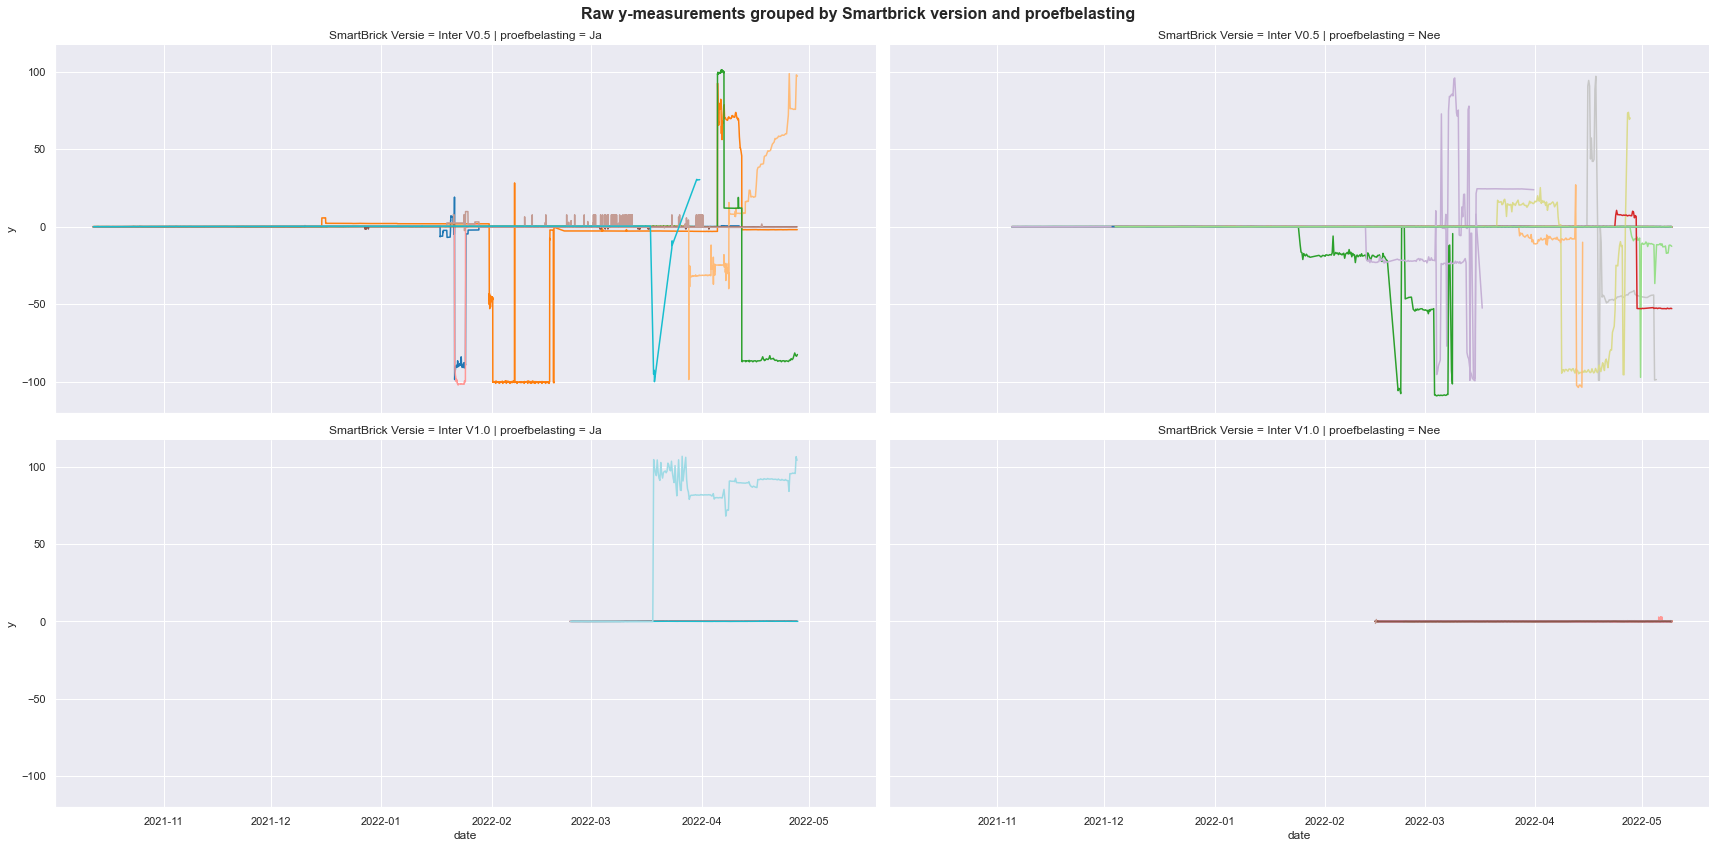

In [11]:
ax = sns.relplot(
    data=train, x='date', y='y',
    row='SmartBrick Versie',
    col='proefbelasting', col_order=train.proefbelasting.sort_values(ascending=True).unique(),
    hue='name', palette='tab20', legend=False,
    kind='line', height=6, aspect=2
)
ax.fig.suptitle('Raw y-measurements grouped by Smartbrick version and proefbelasting', fontsize=16, fontweight='bold')
ax.fig.tight_layout()
plt.show()

In [12]:
y_info = train.groupby(['name', 'SmartBrick Versie', 'Clustercode', 'Datum plaatsing']).agg({'y': ['mean', 'min', 'max']}).y.reset_index()
invalid = y_info.loc[(y_info['min'] < -25) | (y_info['max'] > 25)]
print(f'totaal aantal bricks in filter: {len(y_info)}, totaal met vreemde waarden: {len(invalid)}')
invalid

totaal aantal bricks in filter: 86, totaal met vreemde waarden: 15


name SmartBrick Versie Clustercode Datum plaatsing       mean  \
0   141419        Inter V0.5  Overamstel      2021-10-11  -0.429439   
1   141422        Inter V0.5  Overamstel      2021-10-11  -0.413681   
4   141427        Inter V0.5  Overamstel      2021-10-11  -2.097215   
6   141429        Inter V0.5  Overamstel      2021-10-11   0.416658   
7   141431        Inter V0.5  Overamstel      2021-10-11 -11.403813   
9   141433        Inter V0.5  Overamstel      2021-10-11   0.419293   
11  141435        Inter V0.5     PRG0701      2021-11-04  -0.816635   
13  141437        Inter V0.5     PRG0701      2021-11-04  -7.051153   
15  141439        Inter V0.5     PRG0701      2021-11-04 -12.159425   
25  147360        Inter V0.5     KBW0102      2021-12-02  -4.051057   
26  147361        Inter V0.5     KBW0102      2021-12-02   4.830402   
29  147364        Inter V0.5     GDK0203      2021-12-03  -2.467553   
43  147379        Inter V0.5     SIN0401      2021-12-03  -2.073364   
45  147381        Inter V0.5     PRG1002      2021-12-02  -8.585685   
81  148091        Inter V1.0  Overamstel      2022-02-22  57.302405   

           min         max  
0  -102.279053    1.737061  
1   -98.754883   19.110107  
4   -98.752441   98.867187  
6  -100.097046   30.542603  
7  -101.226807   92.657471  
9   -87.258911  101.358032  
11  -97.326050    0.140991  
13  -99.517822   10.272217  
15 -109.255981    0.405884  
25  -99.221802   97.140503  
26  -99.233398   96.042480  
29  -53.033447   10.546875  
43 -103.852539   27.012939  
45  -95.657349   73.831177  
81   -0.103149  106.647339

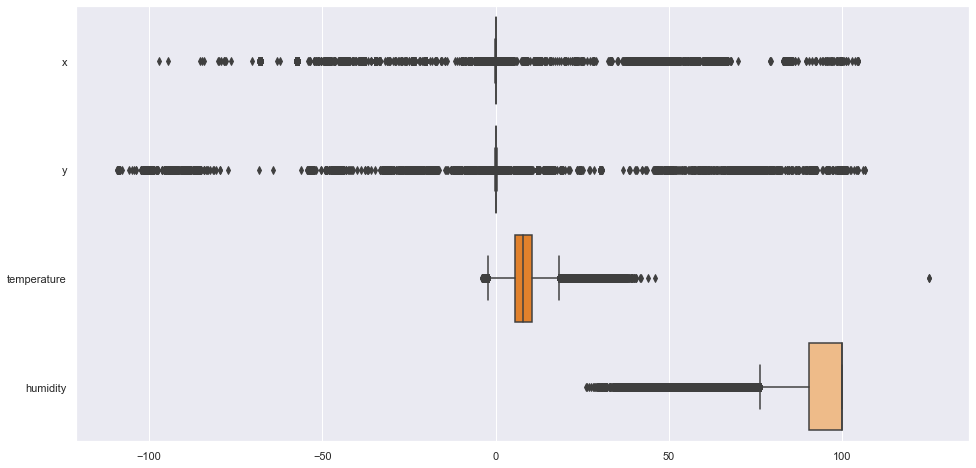

In [13]:
# selecting numerical features
num_features = ['x', 'y', 'temperature', 'humidity']

# plotting boxplot for y measurements
plt.subplots(figsize=(16, 8))

ax = sns.boxplot(data=train[num_features], orient="h", palette='tab20')

plt.show()

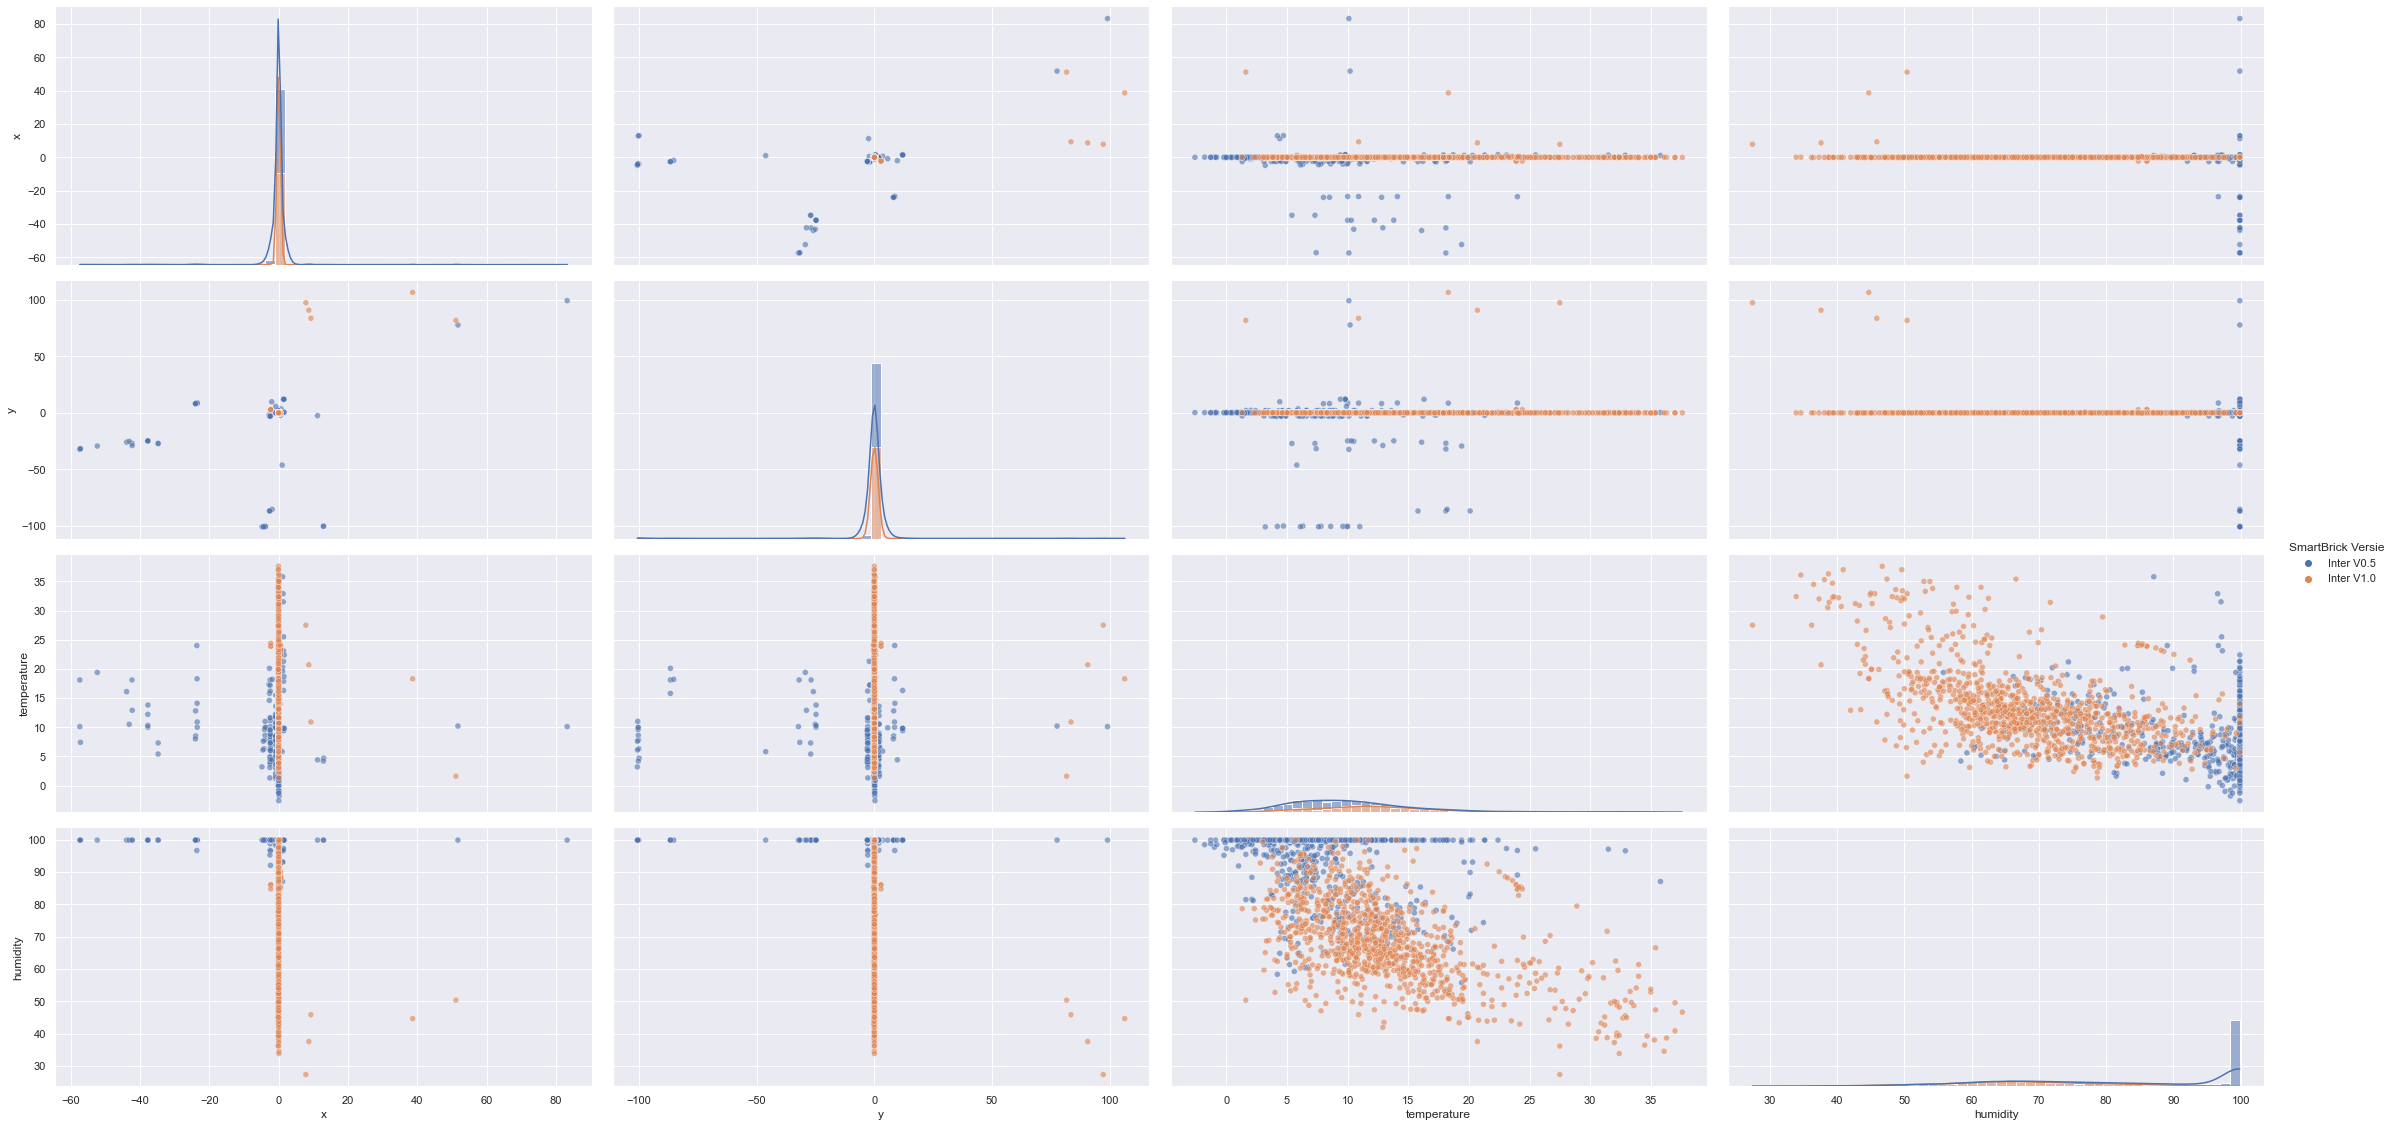

In [14]:
g = sns.PairGrid(train[num_features + ['SmartBrick Versie']].groupby('SmartBrick Versie').sample(1000, random_state=random_seed), hue='SmartBrick Versie', height=4, aspect=2)#, palette='tab20')

g.map_diag(sns.histplot, bins=50, kde=True, multiple='stack')
g.map_offdiag(sns.scatterplot, alpha=.6)
g.add_legend()

plt.show()

In the raw dataset, we're spotting some measurements that are outliers. Let's remove these by using the full data distribution.

Before transform: 168767 rows --> After: 149064 rows


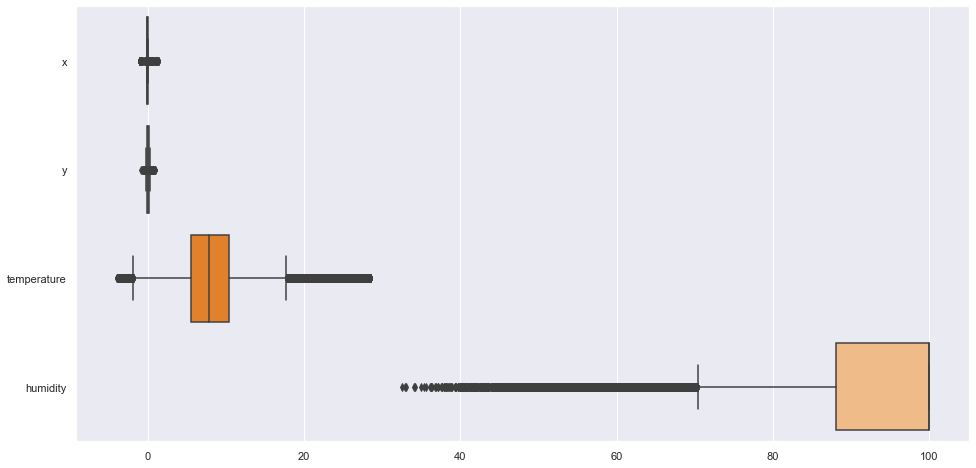

In [15]:
# initialize transformer
transformer = TargetTransformer(IQR=True, q=[.1, .9])
# transform data based on outliers in y measurements
tf_train = transformer.fit_transform(train, cols=['x', 'y', 'temperature'])
print(f"Before transform: {len(train)} rows --> After: {len(tf_train)} rows")

# plotting boxplot for y measurements
plt.subplots(figsize=(16, 8))

ax = sns.boxplot(data=tf_train[num_features], orient="h", palette='tab20')

plt.show()

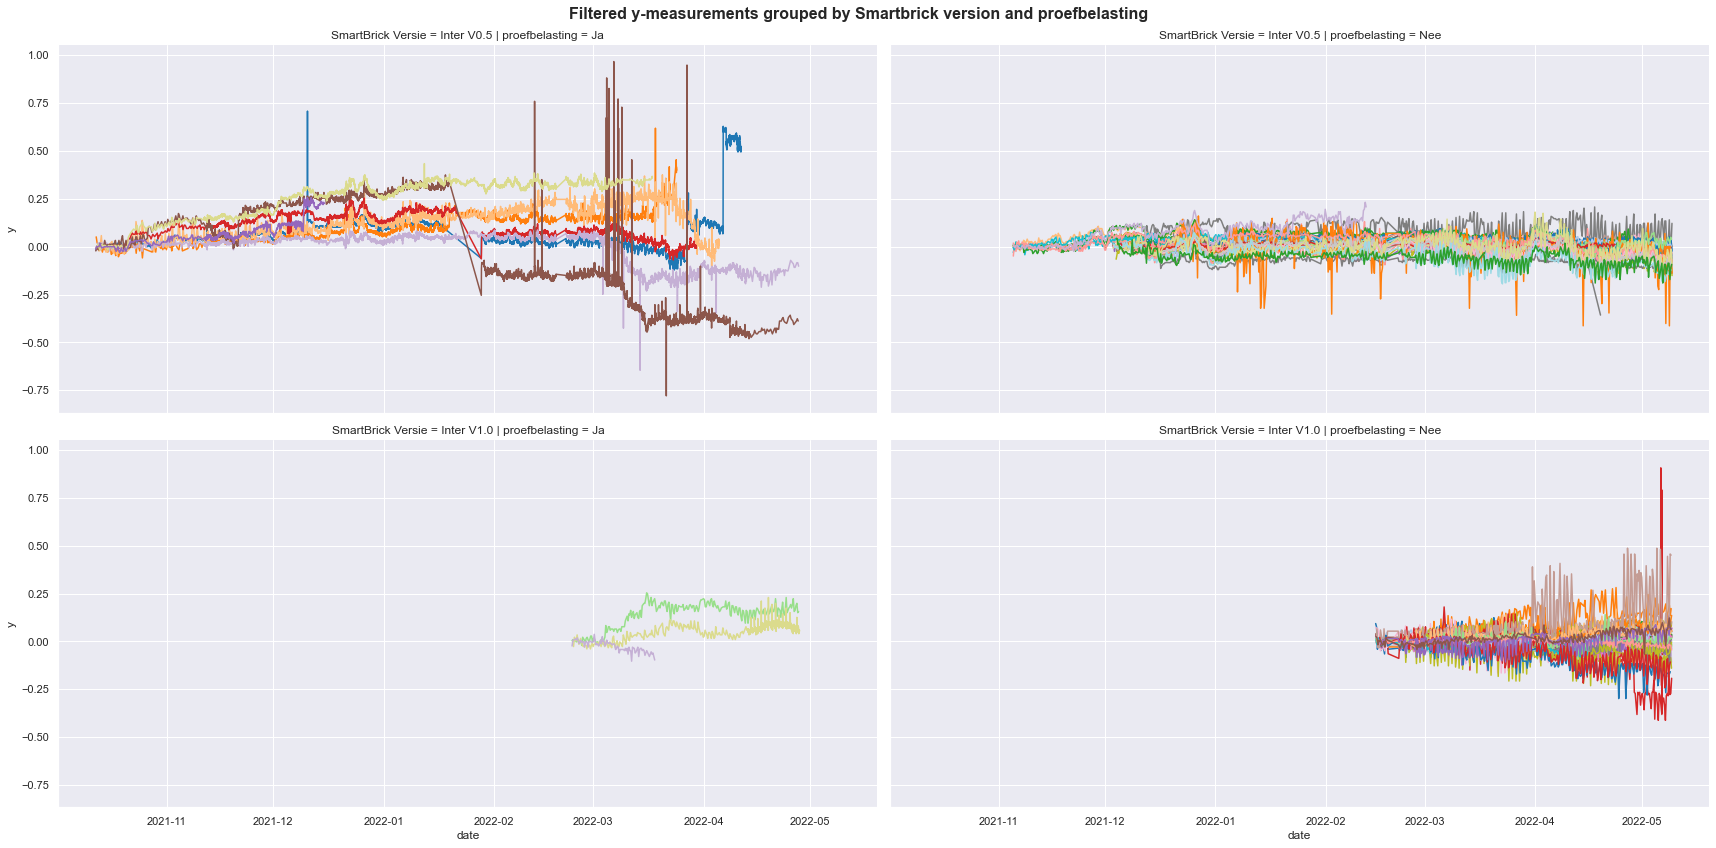

In [16]:
ax = sns.relplot(
    data=tf_train, x='date', y='y',
    row='SmartBrick Versie',
    col='proefbelasting', col_order=tf_train.proefbelasting.sort_values(ascending=True).unique(),
    hue='name', palette='tab20', legend=False,
    kind='line', height=6, aspect=2
)
ax.fig.suptitle('Filtered y-measurements grouped by Smartbrick version and proefbelasting', fontsize=16, fontweight='bold')
ax.fig.tight_layout()
plt.show()

The ranges of measurements are much tighter, but there are some obvious spikes visible in the y measurements. We'll try to remove these by applying a new transformer on each brick.

Before transform: 149064 rows --> After: 147896 rows


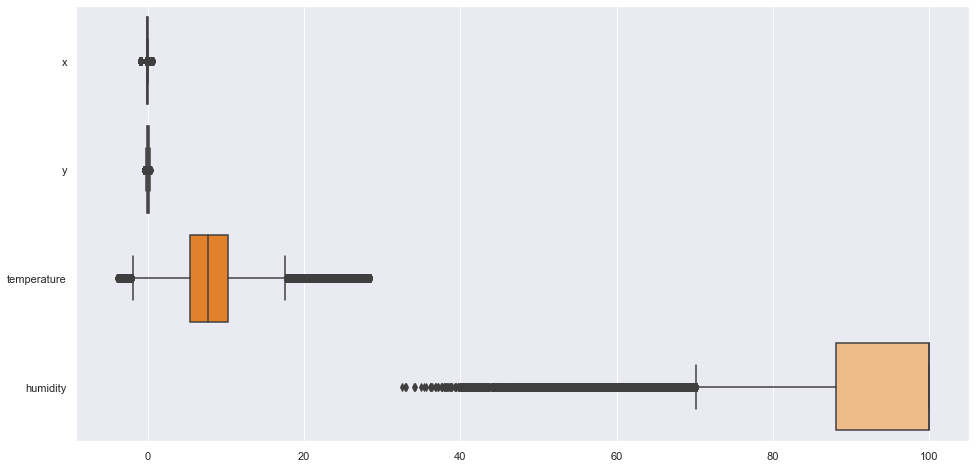

In [17]:
# initialize transformer
transformer = TargetTransformer(IQR=True, trim_spikes=True, q=[.1, .9], d=1.5, period=5)
# transform data based on outliers in y measurements
tf_train2 = tf_train.sort_values('date', ascending=True).groupby('id')\
    .apply(lambda x: transformer.fit_transform(x, cols=['x', 'y'])).reset_index(drop=True)
print(f"Before transform: {len(tf_train)} rows --> After: {len(tf_train2)} rows")

# plotting boxplot for y measurements
plt.subplots(figsize=(16, 8))

ax = sns.boxplot(data=tf_train2[num_features], orient="h", palette='tab20')

plt.show()

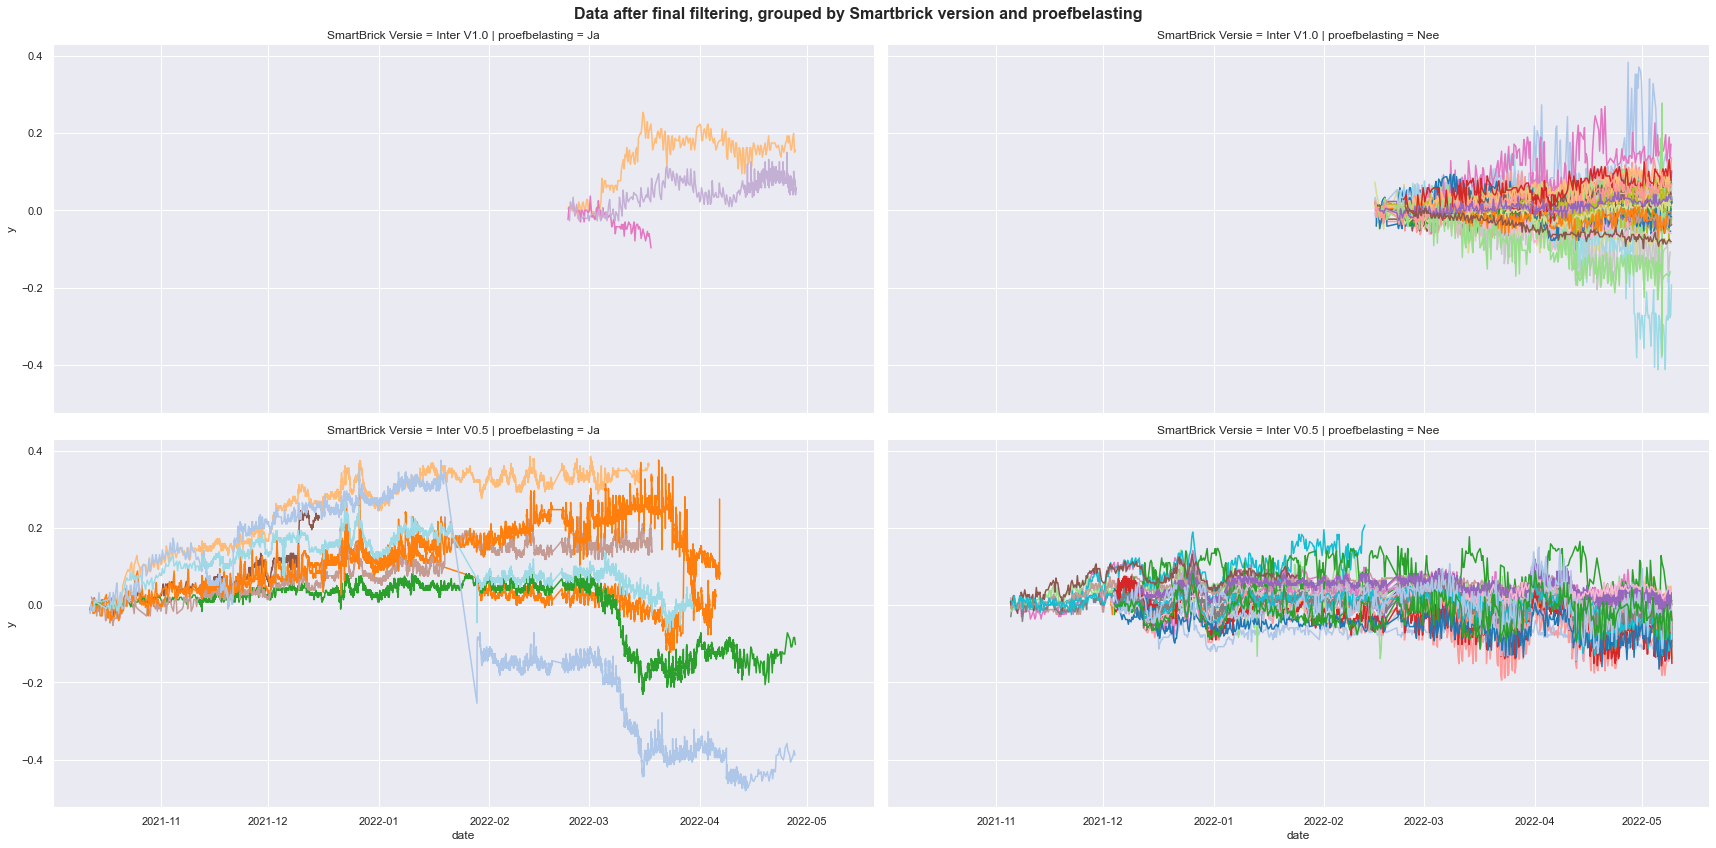

In [18]:
ax = sns.relplot(
    data=tf_train2, x='date', y='y',
    row='SmartBrick Versie',
    col='proefbelasting', col_order=tf_train2.proefbelasting.sort_values(ascending=True).unique(),
    hue='name', palette='tab20', legend=False,
    kind='line', height=6, aspect=2
)
ax.fig.suptitle('Data after final filtering, grouped by Smartbrick version and proefbelasting', fontsize=16, fontweight='bold')
ax.fig.tight_layout()
plt.show()

Much better now! It looks like most outliers and spikes are gone, so we can continue our analysis.

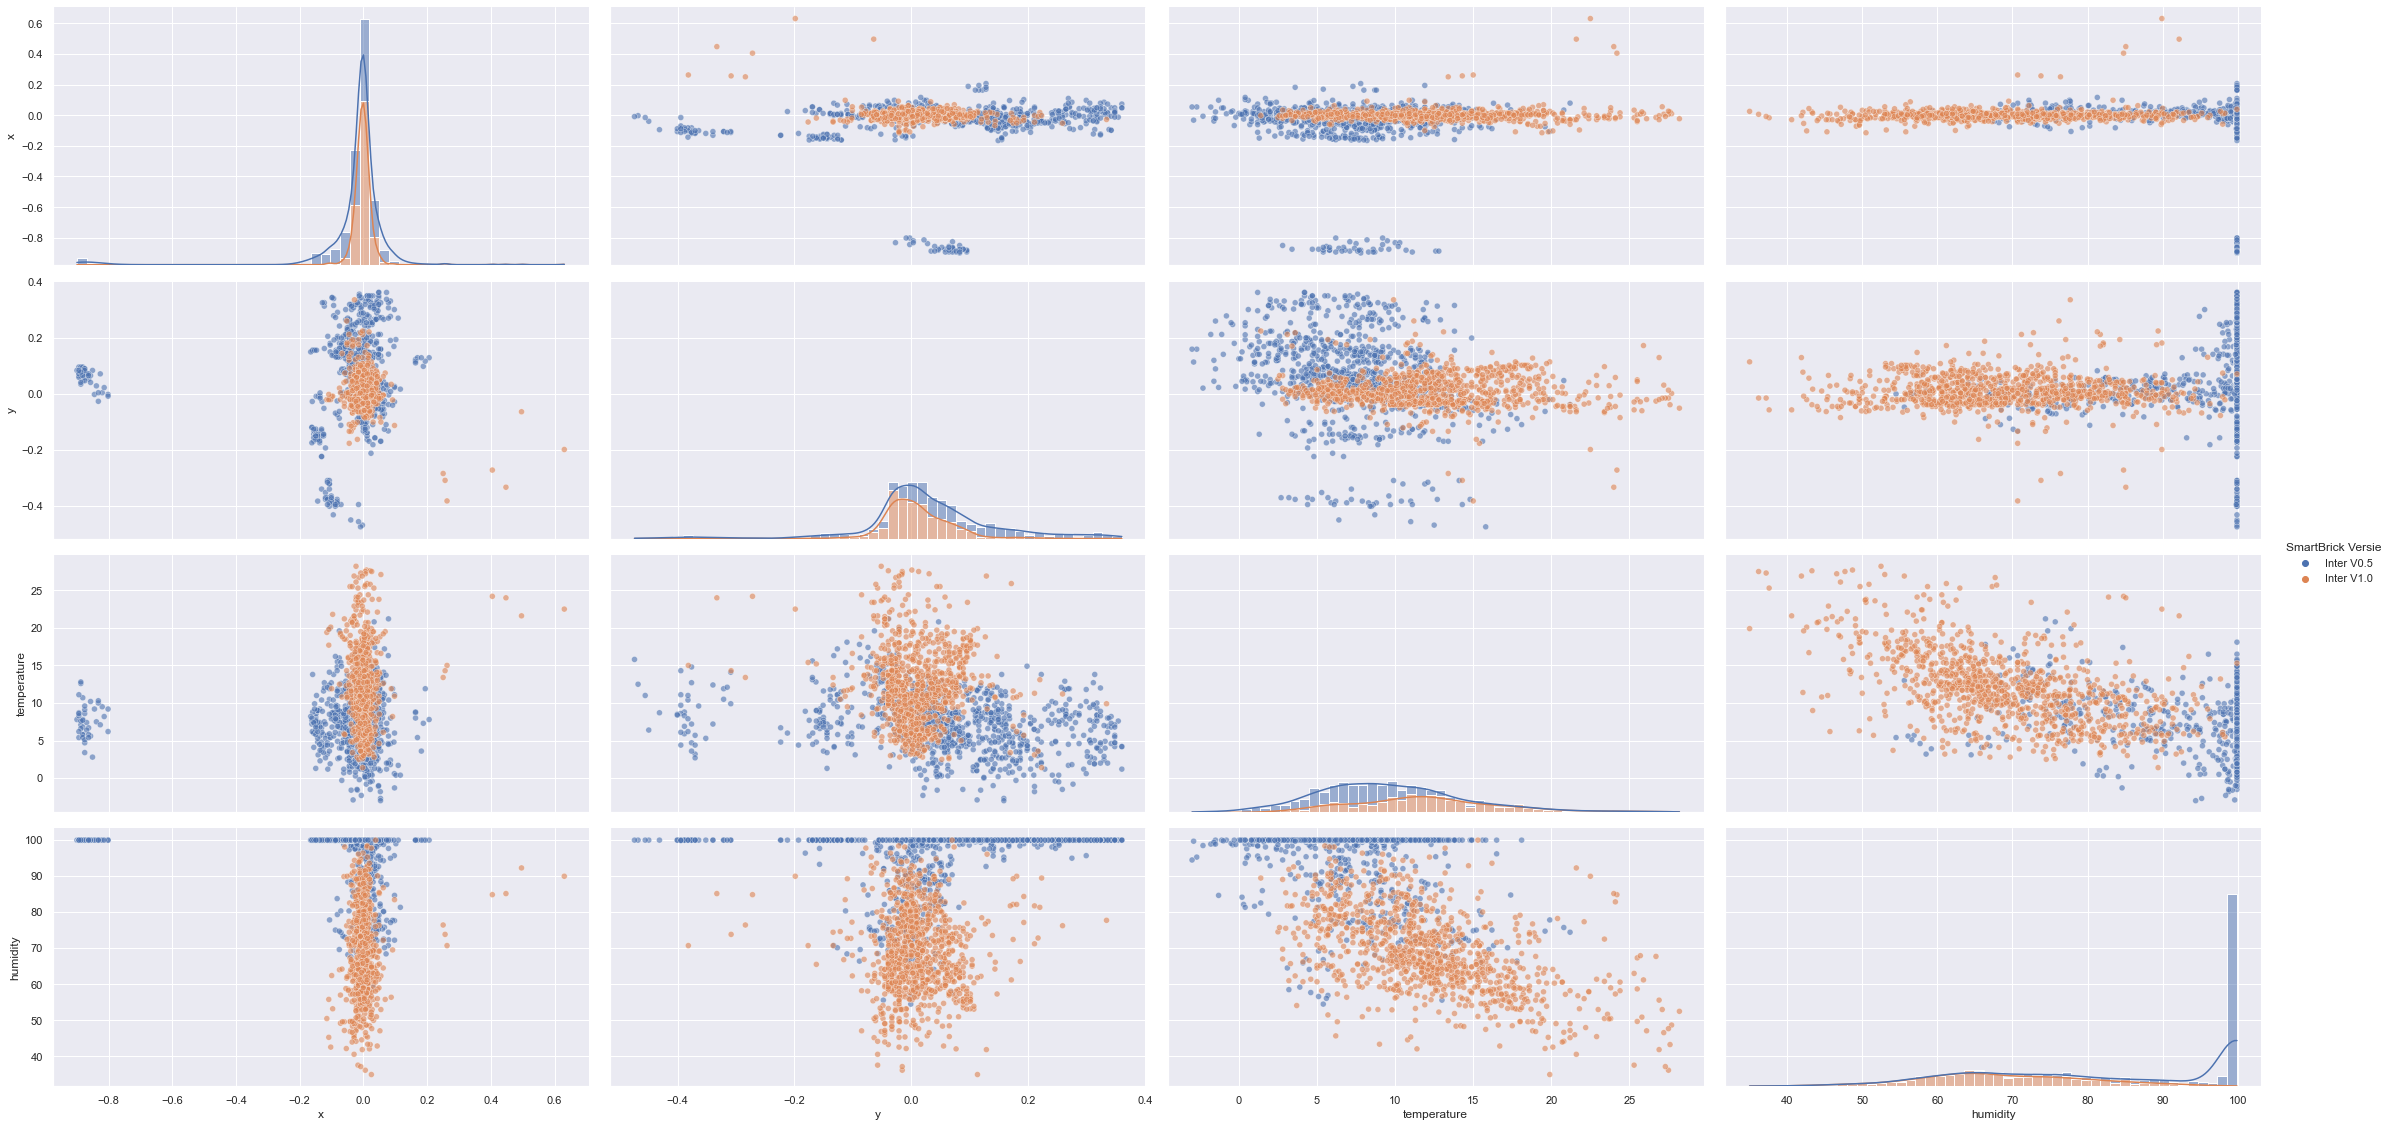

In [19]:
g = sns.PairGrid(tf_train2[num_features + ['SmartBrick Versie']].groupby('SmartBrick Versie').sample(1000, random_state=random_seed), hue='SmartBrick Versie', height=4, aspect=2)#, palette='tab20')

g.map_diag(sns.histplot, bins=50, kde=True, multiple='stack')
g.map_offdiag(sns.scatterplot, alpha=.6)
g.add_legend()

plt.show()

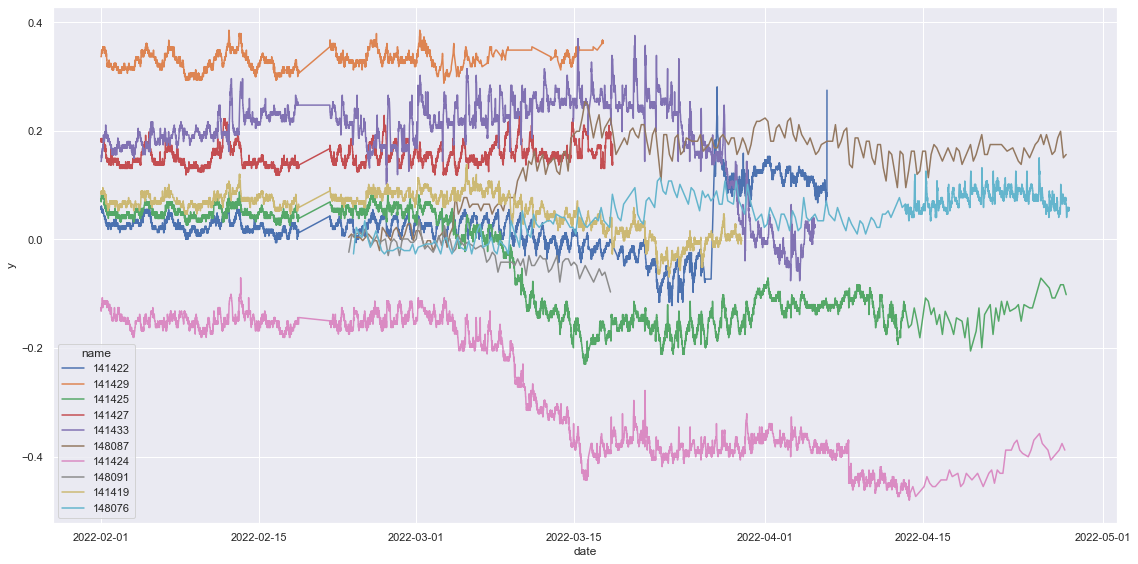

In [20]:
plt.subplots(figsize=(16, 8))

filter = ((tf_train2['proefbelasting'] == 'Ja') & (tf_train2['date'].dt.date >= date(2022,2,1)) & (tf_train2['date'].dt.date <= date(2022,4,27)))

ax = sns.lineplot(data=tf_train2.loc[filter], x='date', y='y', hue='name')
#ax2 = ax.twinx()
#ax2 = sns.lineplot(data=tf_train2.loc[filter], x='date', y='x', color='b')
#ax3 = sns.lineplot(data=new.loc[filter], x='date', y='y_trf', color='b', ax=ax)

plt.tight_layout()
plt.show()

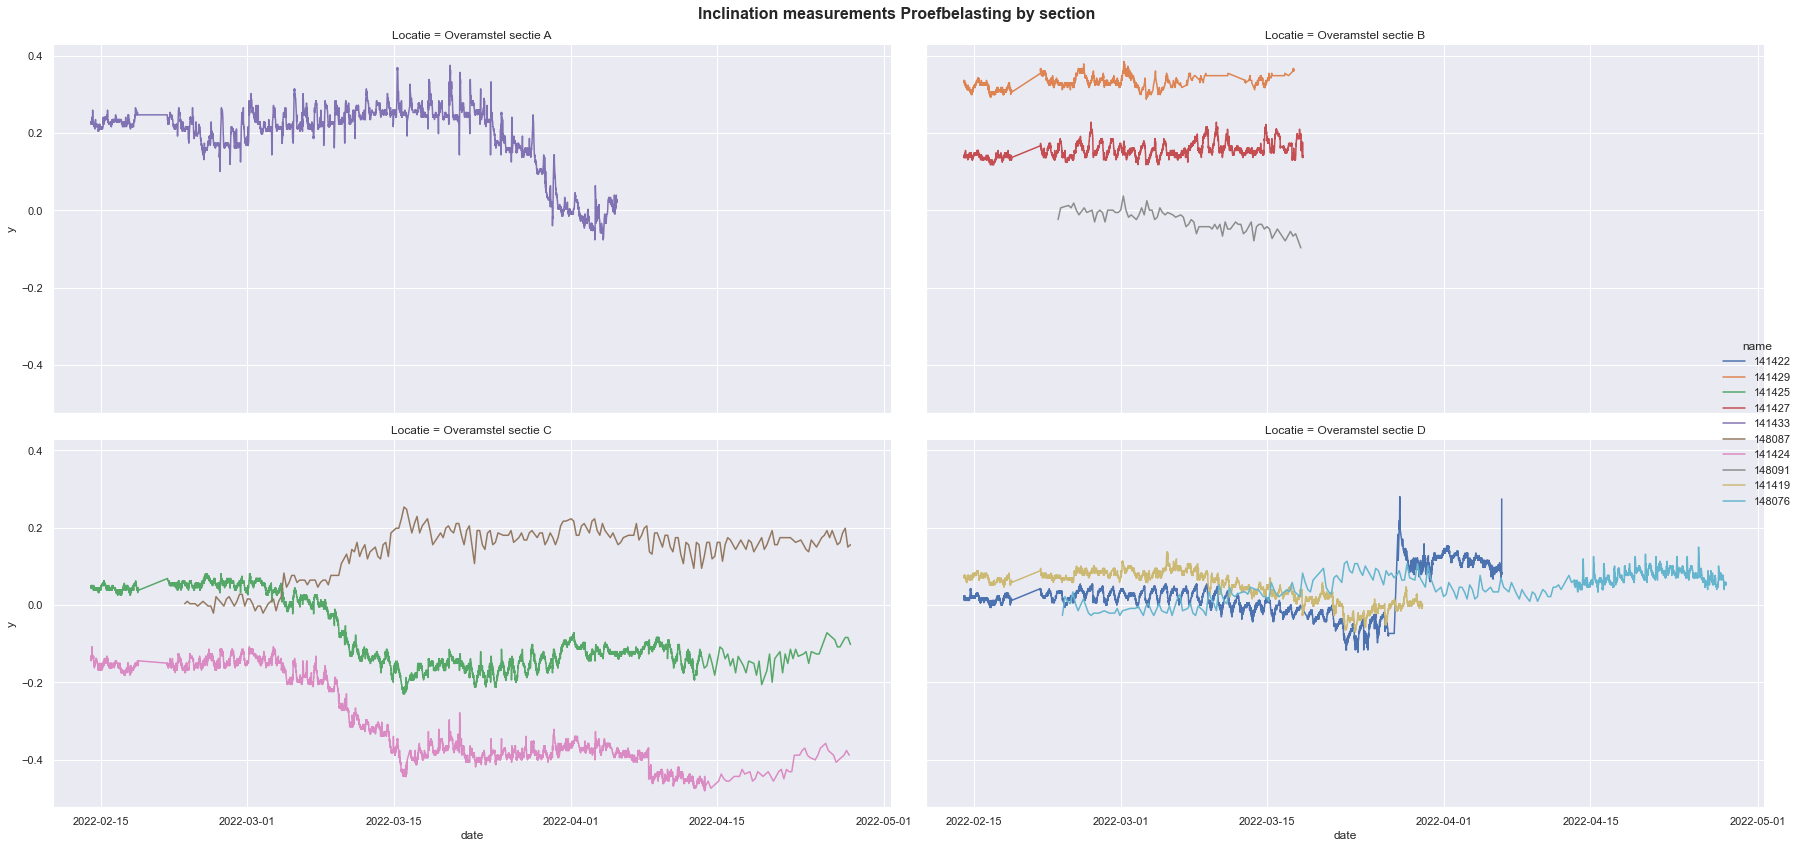

In [21]:
filter = ( (tf_train2['proefbelasting'] == 'Ja') & (tf_train2['date'].dt.date >= date(2022,2,14)) )

ax = sns.relplot(
    data=tf_train2.loc[filter], x='date', y='y',
    col='Locatie', col_order=tf_train2.loc[filter].Locatie.sort_values(ascending=True).unique(),
    hue='name',
    kind='line', height=6, aspect=2, col_wrap=2
)
ax.fig.suptitle('Inclination measurements Proefbelasting by section', fontsize=16, fontweight='bold')
ax.fig.tight_layout()
plt.show()

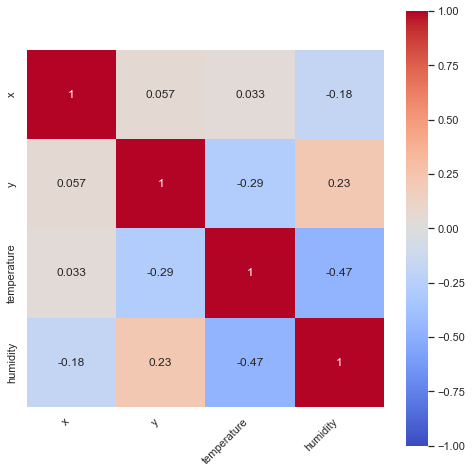

In [22]:
# plotting correlations between numerical columns

plt.subplots(figsize=(8,8))

corr = tf_train2[num_features].corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    annot=True,
    cmap='coolwarm',
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.show()

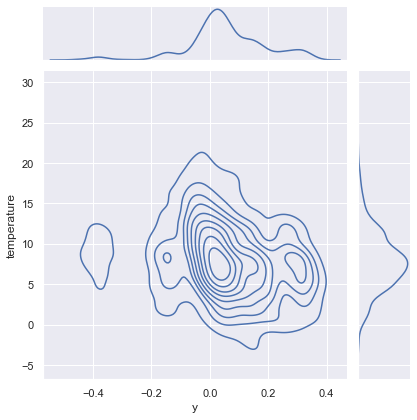

In [23]:
# plotting joint distributions
ax = sns.jointplot(
        data=tf_train2.sample(5000), 
        x="y",
        y="temperature",
        palette='tab20',
        kind='kde'
    )

plt.show()

## Validation

In [24]:
# loading reference data
reference = pd.read_csv('ref_measurements.csv', sep=',', decimal='.', encoding='unicode_escape', index_col=[0])
reference['tijd'] = pd.to_datetime(reference['tijd'])
reference = reference.groupby('location').resample(rule='1H' ,on='tijd').mean().reset_index()
reference = reference.rename(columns={'tijd': 'date', 'Tilt X': 'x', 'Tilt Y': 'y', 'location': 'Locatie'})
reference['name'] = reference.Locatie.apply(lambda x: f"ref {x[18:20]}")
reference['Locatie'] = reference.Locatie.str[0:19]
reference['type'] = 'Referentie'

reference.head()

Locatie                date         x         y   name  \
0  Overamstel sectie A 2022-02-19 06:00:00 -0.000350  0.000700  ref A   
1  Overamstel sectie A 2022-02-19 07:00:00 -0.000500  0.000825  ref A   
2  Overamstel sectie A 2022-02-19 08:00:00 -0.000325  0.000375  ref A   
3  Overamstel sectie A 2022-02-19 09:00:00 -0.000550  0.001625  ref A   
4  Overamstel sectie A 2022-02-19 10:00:00 -0.000725  0.002825  ref A   

         type  
0  Referentie  
1  Referentie  
2  Referentie  
3  Referentie  
4  Referentie

In [25]:
# filter smart brick data and prepare for merge
pb = tf_train2.loc[filter].groupby(['name', 'Locatie']).resample(rule='1H', on='date').mean().dropna().reset_index()
# determining value at start of measurement reference sensors
z = pb.merge(reference.sort_values('date', ascending=True).groupby('Locatie').first()[['date', 'x', 'y']].rename(columns={'date': 'start', 'x': 'ref_x', 'y': 'ref_y'}).reset_index(), on='Locatie')
z = z.loc[z['date'] <= z['start']].groupby('name').last()
# adjusting measurements to reference value
pb['x'] = pb.groupby('name')['x'].apply(lambda x: x - z.loc[x.name].x + z.loc[x.name].ref_x).ewm(span=12, min_periods=12).mean()
pb['y'] = pb.groupby('name')['y'].apply(lambda x: x - z.loc[x.name].y + z.loc[x.name].ref_y).ewm(span=12, min_periods=12).mean()
pb['type'] = 'SmartBrick'

# merge smartbrick data with references
val = pd.concat([pb, reference]).reset_index(drop=True)
val['label'] = 'Sensor ' + val.groupby(['Locatie', 'type']).name.rank("dense", ascending=True).astype(int).astype(str)

# dropping bricks that are showing strange results (new versions, probably different mounting/placement)
val = val.loc[~val['name'].isin(['148076', '148087', '148091'])]

# calculating deltas
val[['delta_x', 'delta_y']] = val.groupby('name')[['x', 'y']].diff(24)#.diff()
val['delta'] = np.sqrt((val[['delta_x', 'delta_y']]**2).sum(axis=1))
val['delta'] = val.groupby('name')['delta'].apply(lambda x: x.ewm(span=24, min_periods=12).mean())
val['delta_y_rm'] = val.groupby('name')['delta_y'].apply(lambda x: abs(x).ewm(span=7, min_periods=7).mean())#.rolling(7, min_periods=7).mean())
val.tail(5)

name              Locatie                date  battery  humidity  \
10629  ref D  Overamstel sectie D 2022-03-24 05:00:00      NaN       NaN   
10630  ref D  Overamstel sectie D 2022-03-24 06:00:00      NaN       NaN   
10631  ref D  Overamstel sectie D 2022-03-24 07:00:00      NaN       NaN   
10632  ref D  Overamstel sectie D 2022-03-24 08:00:00      NaN       NaN   
10633  ref D  Overamstel sectie D 2022-03-24 09:00:00      NaN       NaN   

       rsrp  temperature         x         y        type     label   delta_x  \
10629   NaN          NaN  0.044668 -0.063157  Referentie  Sensor 1 -0.000087   
10630   NaN          NaN  0.044629 -0.064525  Referentie  Sensor 1  0.000731   
10631   NaN          NaN  0.044387 -0.062266  Referentie  Sensor 1  0.000638   
10632   NaN          NaN  0.042024 -0.051982  Referentie  Sensor 1  0.000581   
10633   NaN          NaN  0.047670 -0.046335  Referentie  Sensor 1  0.006370   

        delta_y     delta  delta_y_rm  
10629  0.018162  0.016148    0.017729  
10630  0.005387  0.015291    0.014644  
10631  0.005634  0.014521    0.012391  
10632  0.007952  0.013997    0.011281  
10633  0.007708  0.013678    0.010388

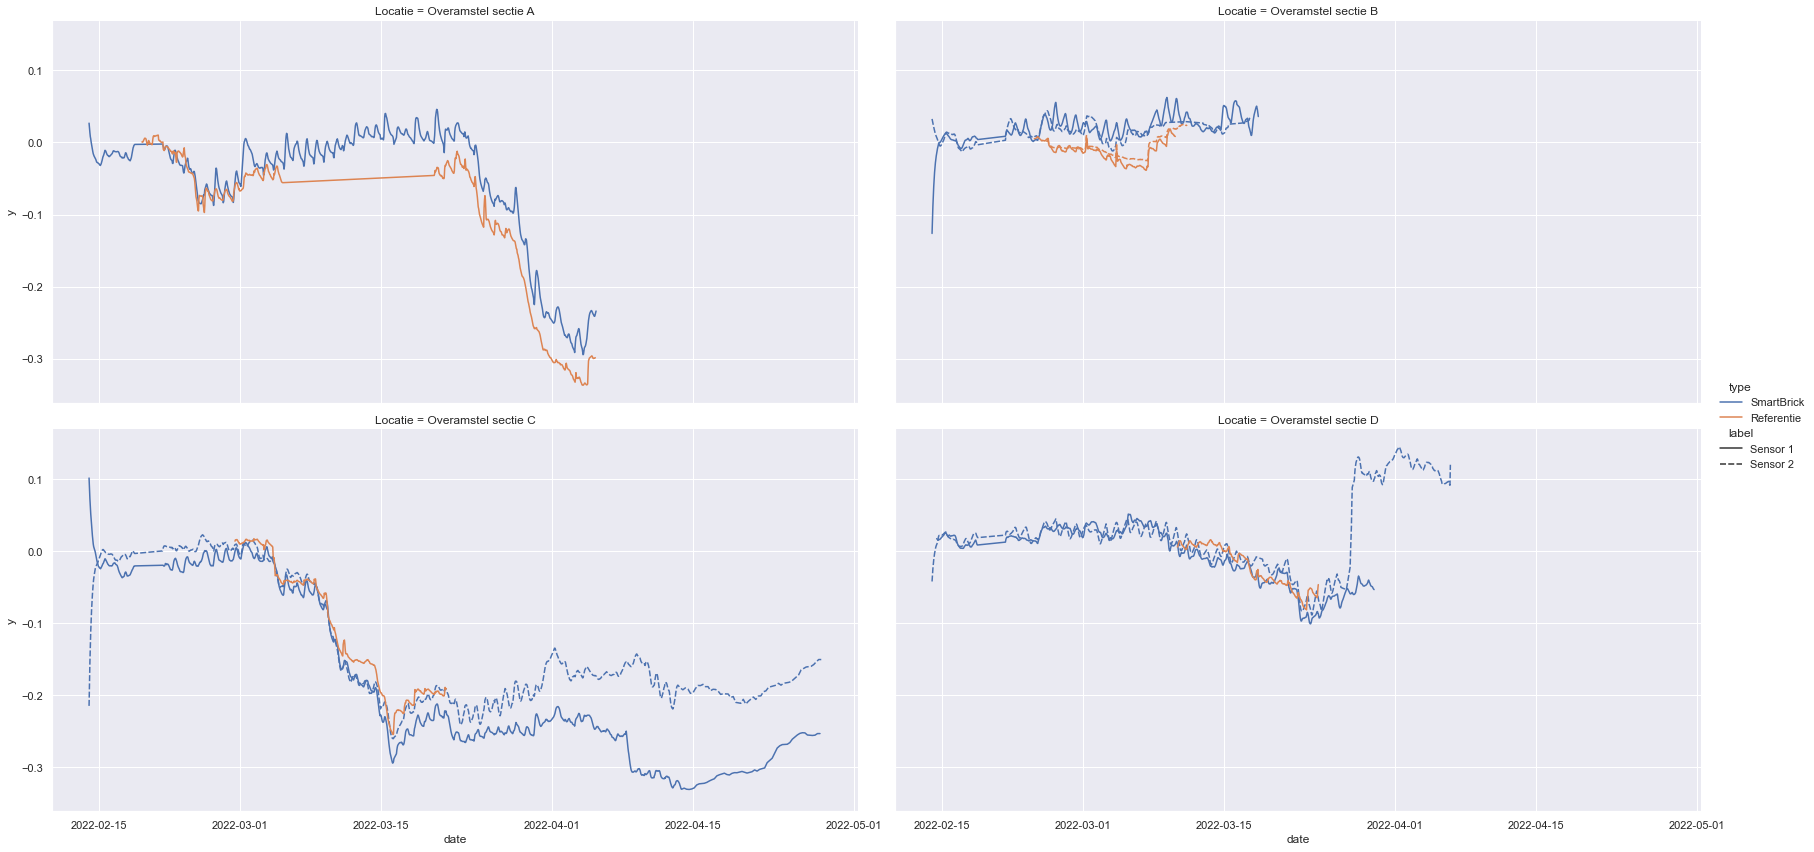

In [26]:
ax = sns.relplot(
    data=val, x='date', y='y',
    col='Locatie', col_order=val.Locatie.sort_values(ascending=True).unique(),
    hue='type', style='label',
    kind='line', height=6, aspect=2, col_wrap=2
)

plt.show()

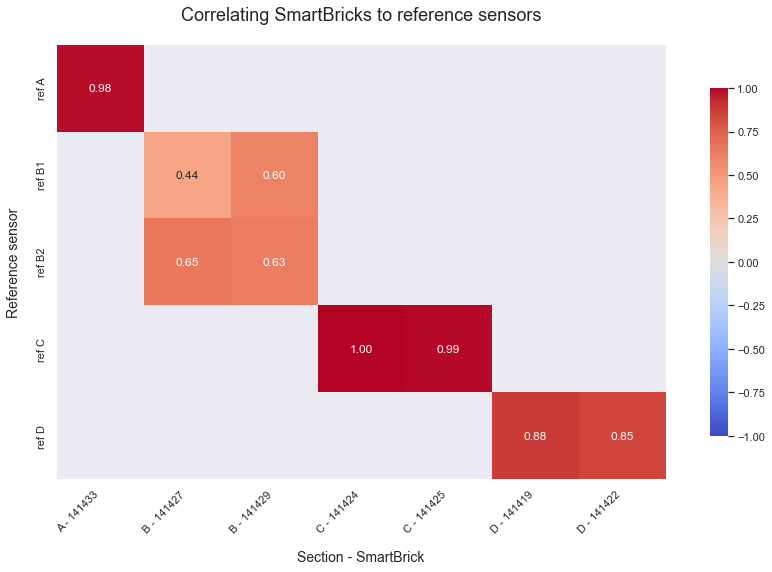

In [28]:
# plotting correlations between sensors

val['sensor_name'] = val.apply(lambda x: f"{x.Locatie[-1]} - {x['name']}" if x.type=='SmartBrick' else x['name'], axis=1)
corr = val.sort_values(['Locatie', 'name']).groupby(['sensor_name', 'date']).y.mean().unstack(level=0).corr().iloc[7:, 0:7]

plt.subplots(figsize=(16, 8))

mask = np.array(
    [
        [1]*0 + [0]*1 + [1]*6,
        [1]*1 + [0]*2 + [1]*4,
        [1]*1 + [0]*2 + [1]*4,
        [1]*3 + [0]*2 + [1]*2,
        [1]*5 + [0]*2 + [1]*0,
    ]
)

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    robust=True,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    square=True,
    cbar_kws={"shrink": 0.8},
    mask=mask
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_xlabel("Section - SmartBrick", size=14, labelpad=16)
ax.set_ylabel("Reference sensor", size=14, labelpad=16)
ax.set_title("Correlating SmartBricks to reference sensors", fontdict={'fontsize':18}, pad=24)

plt.show()

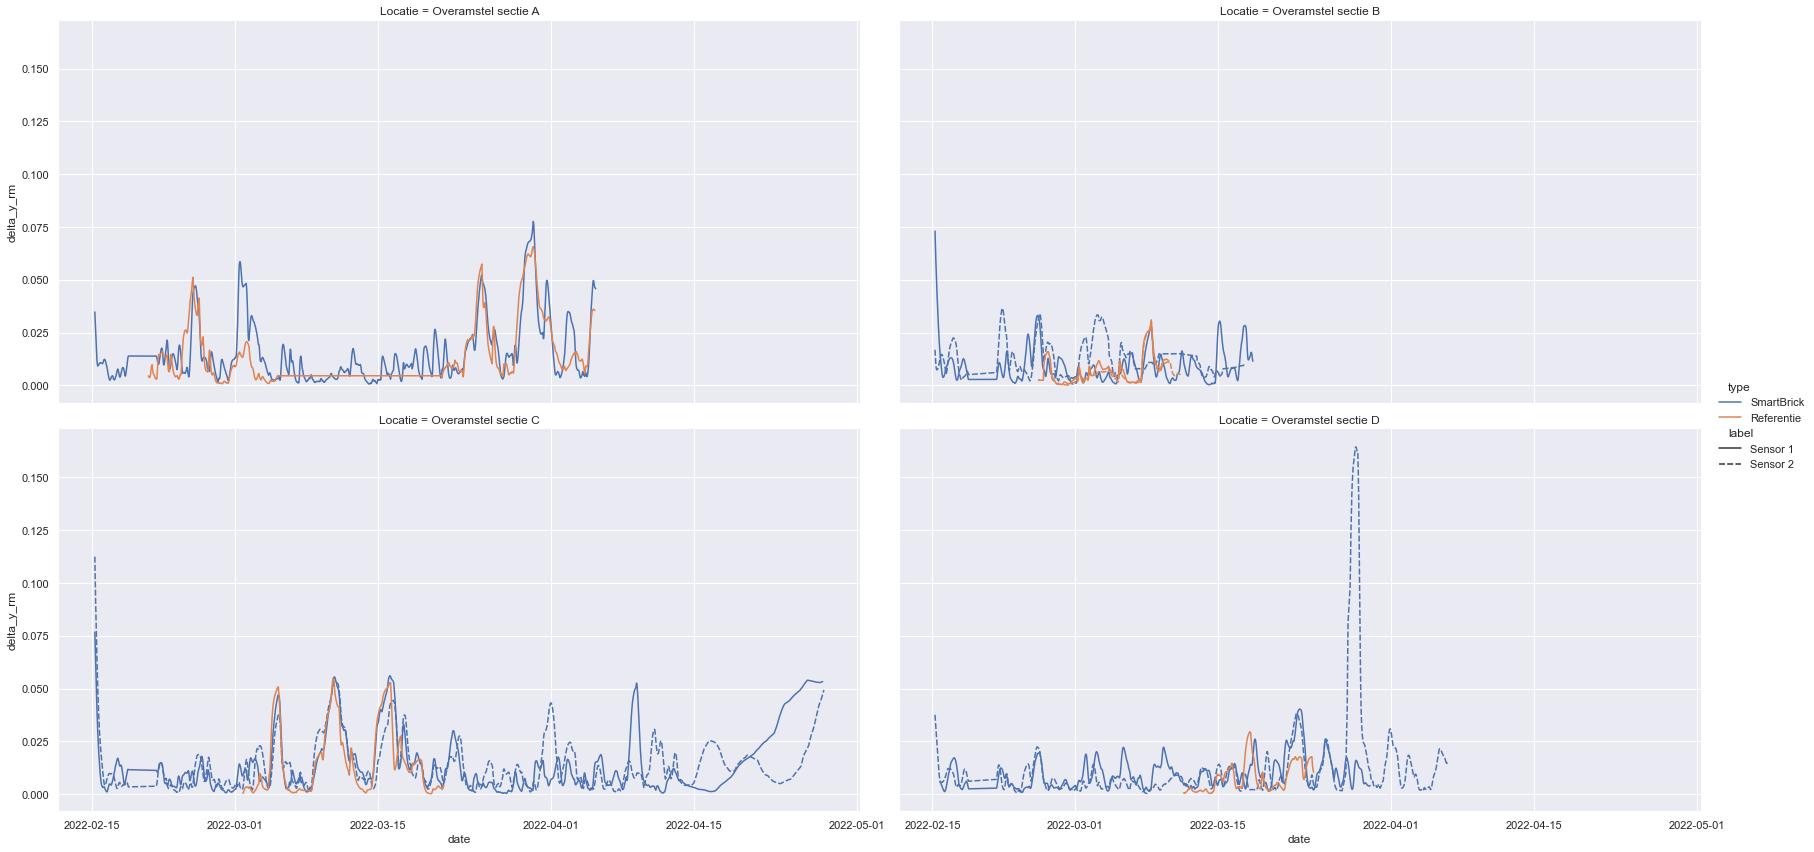

In [29]:
g = sns.relplot(
    # dropping bricks that are showing strange results (new versions, probably different mounting/placement)
    data=val.loc[~val['name'].isin(['148076', '148087', '148091'])],
    x='date', y='delta_y_rm',
    col='Locatie', col_order=val.Locatie.sort_values(ascending=True).unique(),
    hue='type', style='label',
    kind='line', height=6, aspect=2, col_wrap=2
)

plt.show()

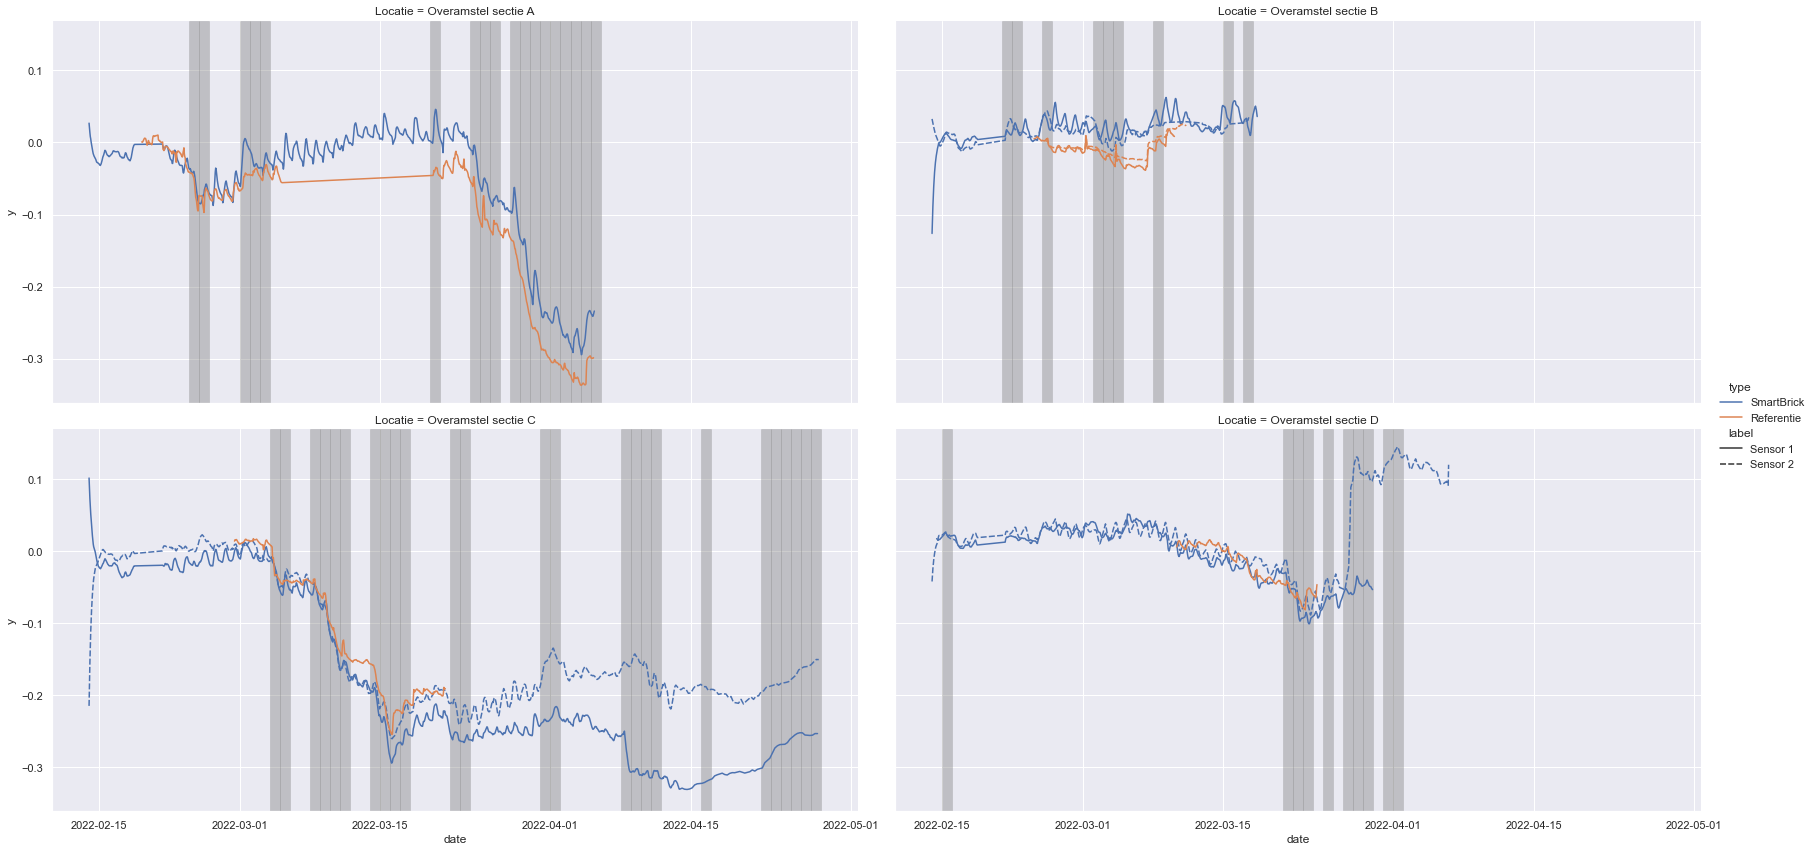

In [30]:
g = sns.relplot(
    # dropping bricks that are showing strange results (new versions, probably different mounting/placement)
    data=val.loc[~val['name'].isin(['148076', '148087', '148091'])],
    x='date', y='y',
    col='Locatie', col_order=val.Locatie.sort_values(ascending=True).unique(),
    hue='type', style='label',
    kind='line', height=6, aspect=2, col_wrap=2
)

for (col_val), ax in g.axes_dict.items():
    mvm = (g.data.loc[(g.data.Locatie == col_val) & (g.data.type == 'SmartBrick') & (g.data.delta_y_rm > .025)].date.dt.date - date(1970, 1, 1)).dt.days.unique()
    for day in mvm[1:]:
        ax.axvspan(day, day+1, color='grey', linewidth=.5, alpha=.4)

plt.show()

In [31]:
def ts_analysis_plots(data, n_lags):  
    
    # AD Fuller test and linear trend of the time series
    trend, coefs = TimeSeriesTransformer.get_trend(data)
    a, b = coefs[0], coefs[1]
    adf = adfuller(data)
    
    fig, axs = plt.subplots(2, 2, figsize=(16, 8))
    axs = axs.flat

    # combine original timeseries with trendline
    df = pd.concat([data, trend], axis=1)

    # calculate a 12 period rolling mean
    df['rolling_mean'] = data.rolling(12, min_periods=1).mean()

    # calculate a 12 period rolling standard deviation
    df['rolling_std'] = data.rolling(12, min_periods=1).std()

    # plot dataframe columns against time
    sns.lineplot(data=df, ax=axs[0])
    axs[0].set(xlabel=data.index.name, ylabel=data.name, 
               title="Timeseries plot of data (ADF p-value: {:.3f}) \n \
                    (Trend: a={:.0f}, b={:.0f})".format(adf[1], coefs[0], coefs[1]))
        
    # histogram of value distribution
    sns.distplot(data, bins=20, hist=True, kde=True, rug=False, fit=norm, ax=axs[1],
                kde_kws={"label": "KDE"})
    axs[1].set(xlabel=data.name, ylabel="probability", title="Distribution of dataset")
    
    # autocorrelation function
    plot_acf(data, lags=n_lags, ax=axs[2])
    axs[2].set(xlabel="lag", ylabel="ACF value")
    
    # partial autocorrelation function
    plot_pacf(data, lags=n_lags, method='ywm', ax=axs[3])
    axs[3].set(xlabel="lag", ylabel="PACF value")
    
    plt.tight_layout()
    plt.show()

C:\Users\SebastiaanHemmer\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


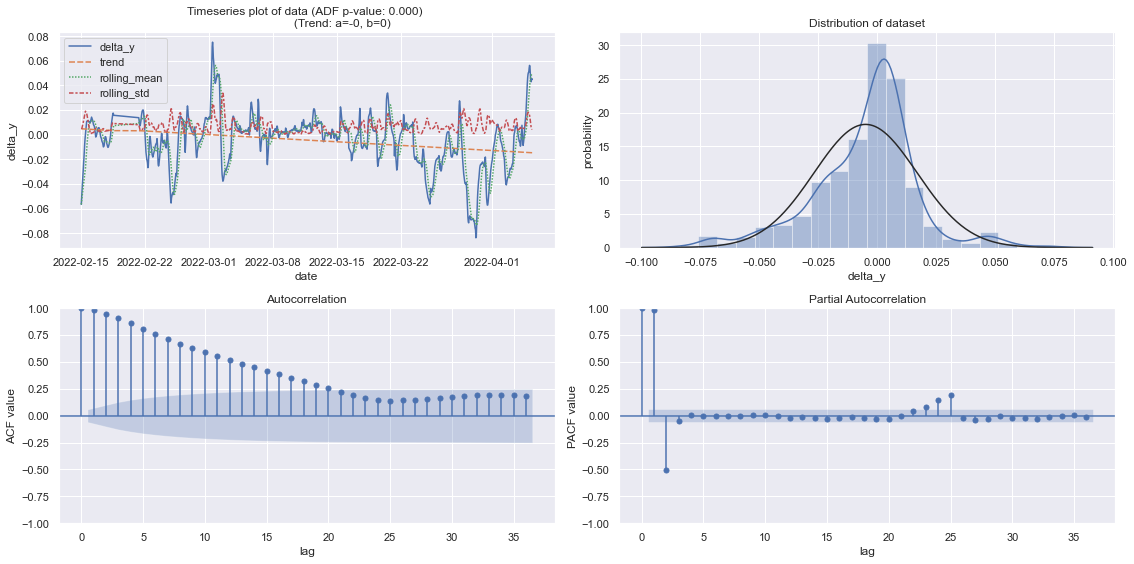

ADF Statistic: -5.11
p-value: 0.00
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [32]:
y = val.loc[val['name'] == '141433'].set_index('date')['delta_y'].dropna()#.resample('M').sum()['Demand_m3']

# Generate plots and calculate ADF values
ts_analysis_plots(y, 36)

# check if dataframe is stationary
result = adfuller(y)
print('ADF Statistic: {:.2f}'.format(result[0]))
print('p-value: {:.2f}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

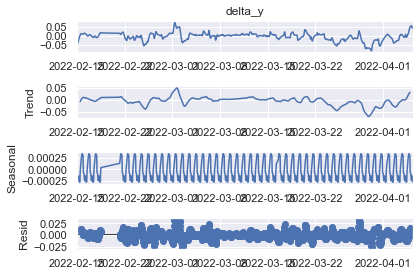

In [33]:
result = seasonal_decompose(y, model='additive', period=24)
result.plot()

plt.show()

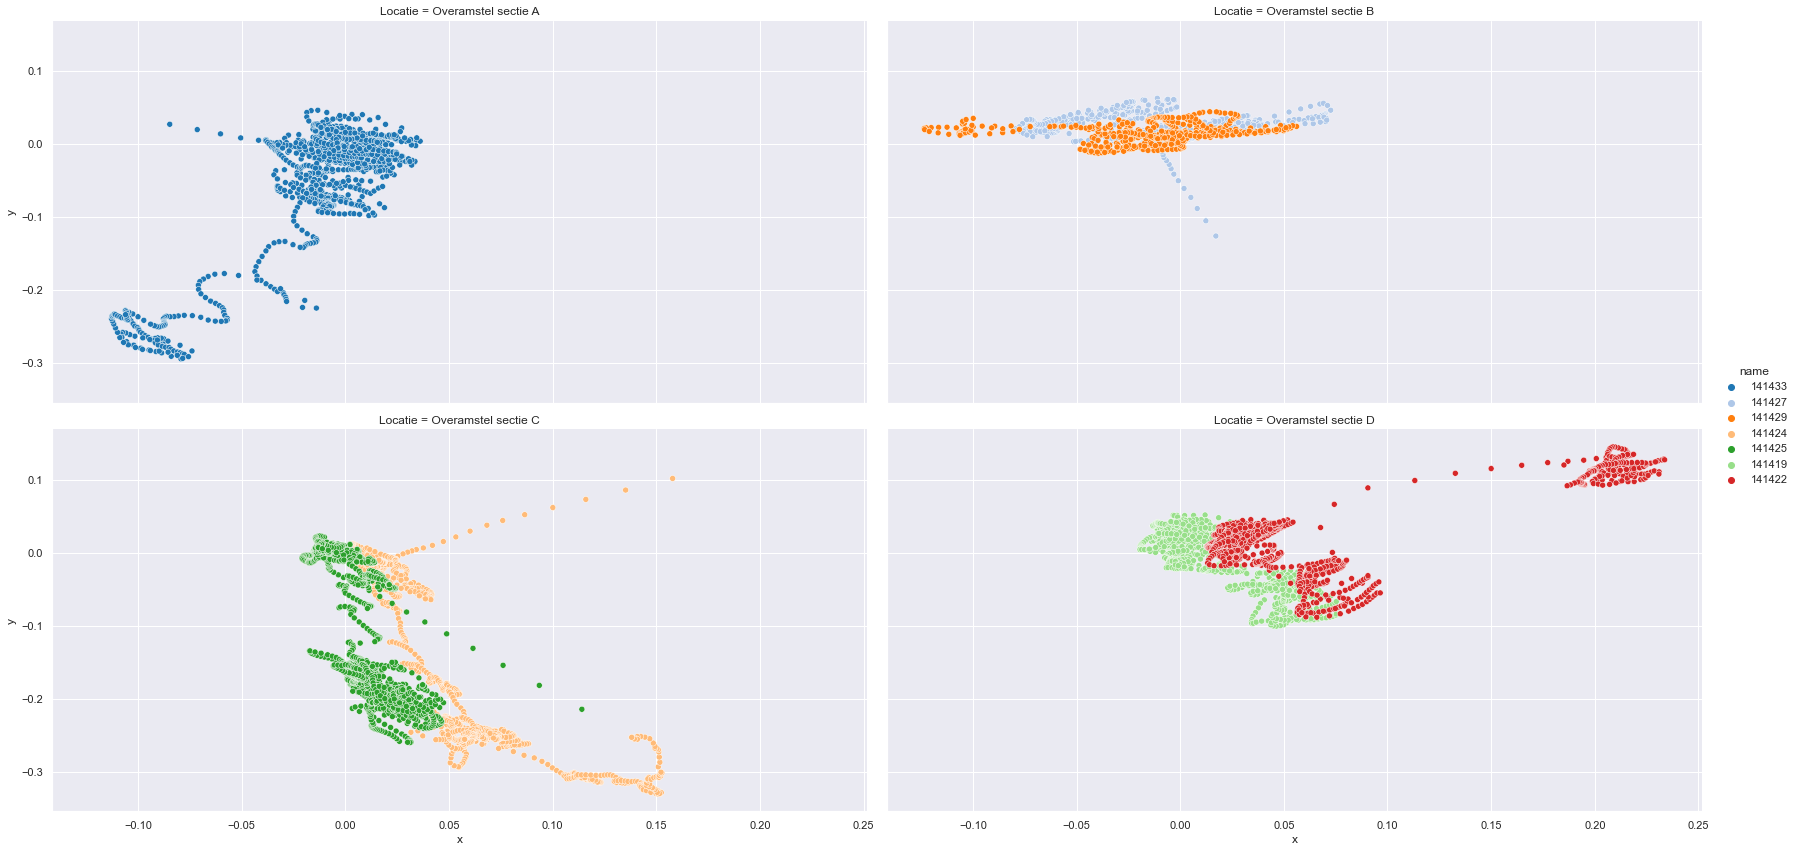

In [34]:
sns.relplot(
    data=val.loc[val.type == 'SmartBrick'].sort_values(['Locatie', 'name']), x='x', y='y',
    col='Locatie', col_wrap=2, hue='name',
    kind='scatter', height=6, aspect=2, palette='tab20'
)

plt.show()

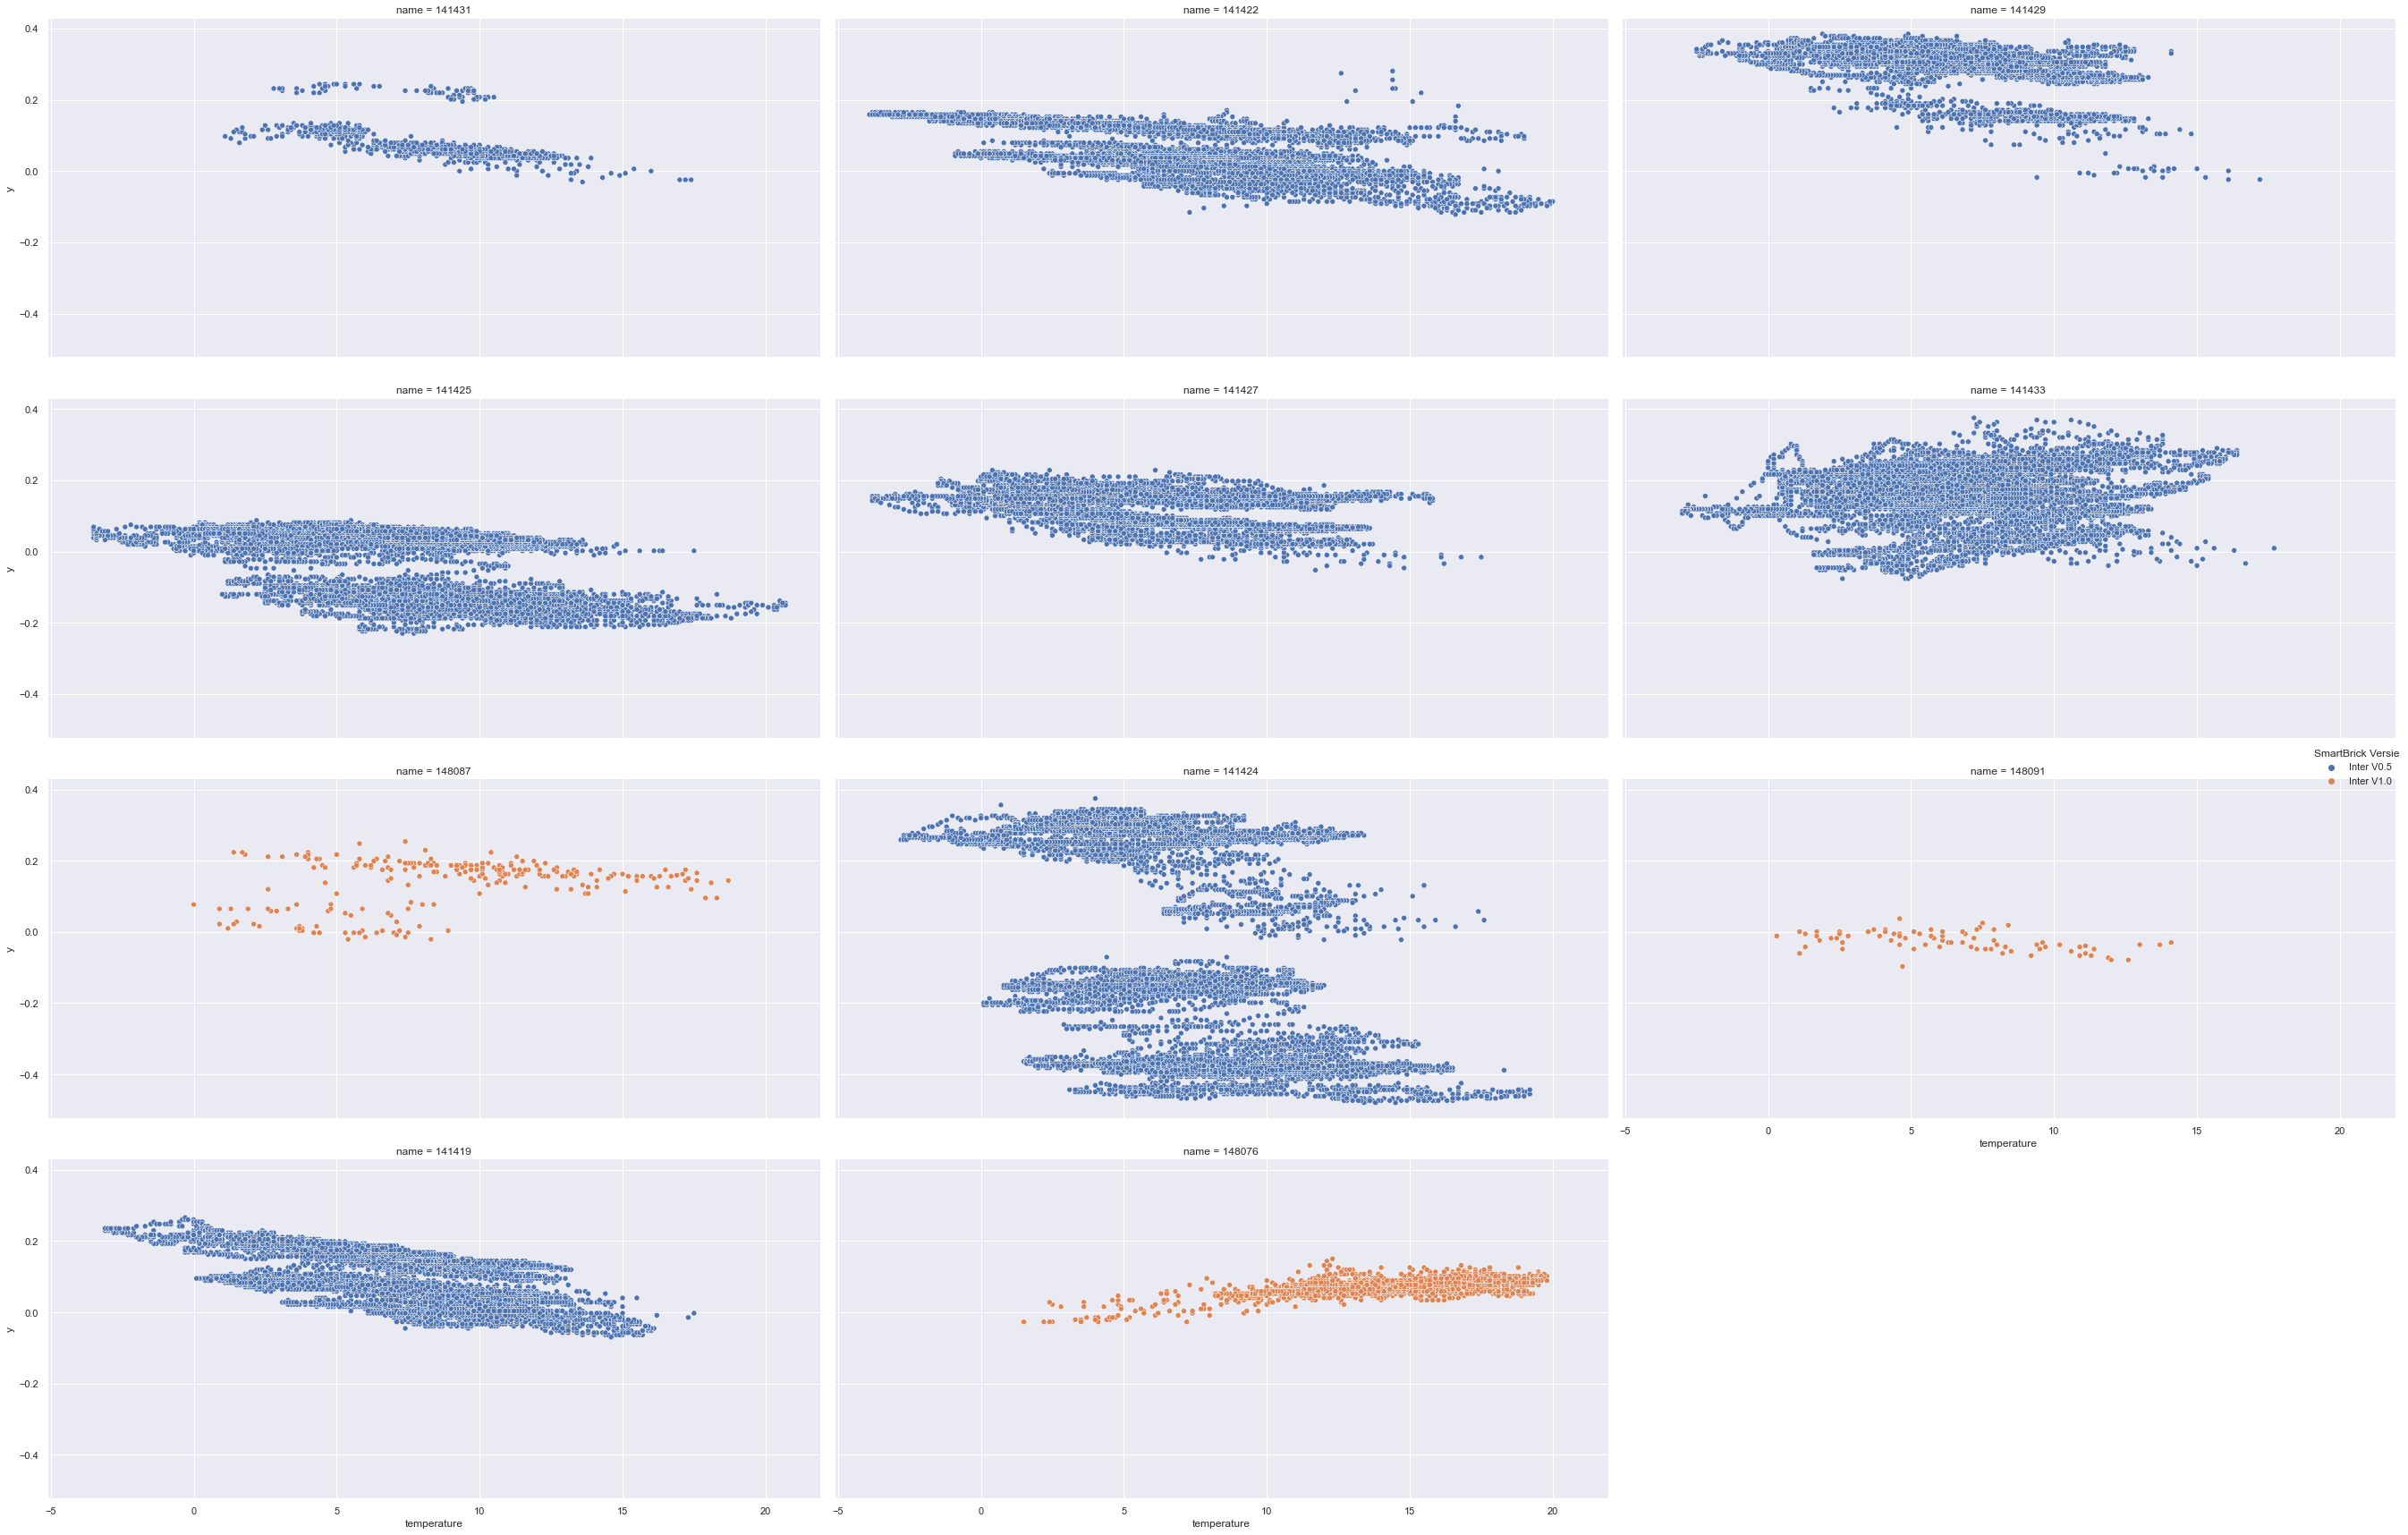

In [36]:
sns.relplot(
    data=tf_train2.loc[tf_train2.proefbelasting == 'Ja'], x='temperature', y='y',
    col='name', col_wrap=3, hue='SmartBrick Versie',
    kind='scatter', height=6, aspect=2
)

plt.tight_layout()
plt.show()

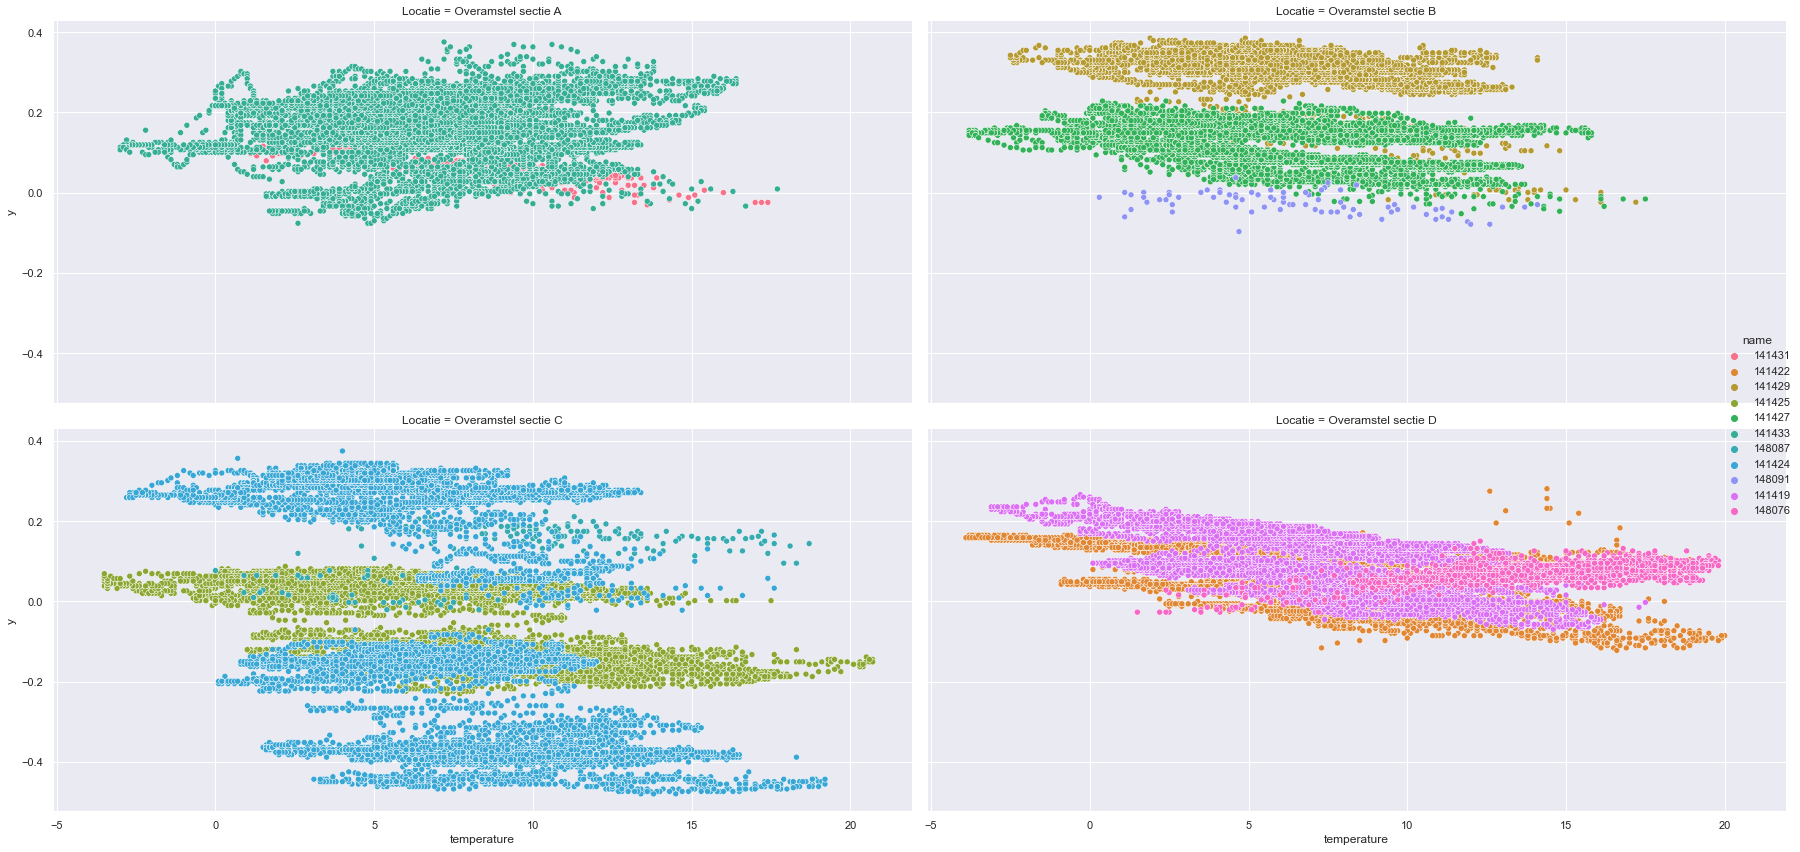

In [37]:
sns.relplot(
    data=tf_train2.loc[tf_train2.proefbelasting == 'Ja'], x='temperature', y='y',
    col='Locatie', col_wrap=2, col_order=val.Locatie.sort_values(ascending=True).unique(),
    hue='name', kind='scatter', height=6, aspect=2
)

plt.tight_layout()
plt.show()

In [38]:
tf_train2.loc[tf_train2.proefbelasting == 'Ja'].sort_values(['Locatie', 'name'], ascending=False).groupby(['name']).head(100).groupby(['name'])[['y', 'temperature']].corr().loc(axis=0)[:, 'y'].temperature#.iloc[:, 0]

name     
141419  y   -0.696889
141422  y   -0.734475
141424  y   -0.436756
141425  y   -0.296355
141427  y   -0.562766
141429  y   -0.580009
141431  y   -0.713345
141433  y   -0.328802
148076  y    0.785709
148087  y    0.454482
148091  y   -0.478440
Name: temperature, dtype: float64

In [39]:
c = tf_train2.loc[tf_train2.proefbelasting == 'Ja'].sort_values(['Locatie', 'name'], ascending=False).groupby(['name', 'date'])[['y', 'temperature']].mean().unstack(level=0).corr().iloc[0:11, 11:]

pd.Series(np.diag(c), index=c.index)

   name  
y  141419   -0.571166
   141422   -0.466059
   141424   -0.340939
   141425   -0.457848
   141427   -0.336658
   141429   -0.470576
   141431   -0.548378
   141433    0.105216
   148076    0.638966
   148087    0.303871
   148091   -0.478440
dtype: float64